<a href="https://colab.research.google.com/github/RachelRamirez/CIFAR-10/blob/main/CollectionofTests/Group-B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Date: Last changed 11/10/2021 at 9:25 pm




Description: shard = 16, corrected cifar10_count order of output (deers/dogs was messedup), corrected shuffle=5000, batch=100 (was 20 and 10 before), updated epoch information* Dr C requested, as well as warning if early stop epochs are really high.  stll need to check if batches are mixing welll and still need to print out/save as csv and still need to pass all the groups through the augmentation

### Imports

In [3]:
#@title import libraries set time
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import os
import PIL
import PIL.Image
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# import keras.utils -- dont do this!! it causes problems, 
from tensorflow.keras.utils import to_categorical  #do this instead!!
import random
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import time
import pickle
from google.colab import files
import datetime # to display the current time hh:mm:ss

# Possibly Need IMGAUG to set seed in ALbumentations
# GitHub Issue: https://github.com/albumentations-team/albumentations/issues/93
import imgaug
imgaug.seed(123)


tic = time.time()  # Start the timer
initial_run = 0

AUTOTUNE = tf.data.experimental.AUTOTUNE
np.set_printoptions(precision=4)

#### Set Random Seeds

In [4]:
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed()  # https://stackoverflow.com/questions/11526975/set-random-seed-programwide-in-python
shuffle_seed = seed
## ------------------

Set Logic-Values


In [5]:
run_model = False  #When Im looking at augmentations, I don't want to keep refitting a model, I want to just get the database of images loaded

Make Image Datasets

One of my biggest learning curves was learning how to load  the dataset with tdfs.load() and then filter on images by label.  

The second biggest was using the created model to make predictions on the test set.   

Current but "skipped" problem is trying to view misclassifeid images of results.


Another area of problems is rerunning when you've already specified a batch on your dataset creates another "batch" split so it can cause problems to rerun a cell that says how to define a dataset.  Unbatch may be needed first.    

### Load Dataset

In [6]:

# A weird problem happened where it said the toronto website cant be reached, if that ever happens again make sure to go to SO for this advice https://stackoverflow.com/questions/36805640/this-error-while-downloading-datasets-valueerror-i-o-operation-on-closed-file

# How do I set IDs on: read_config.add_tfds_id = True
read_config = tfds.ReadConfig(shuffle_seed=seed) 
read_config.add_tfds_id = True  ## This didnt update ReadConfig 

dataset, info = tfds.load('cifar10', as_supervised=True, with_info=True, read_config=read_config)
x_test =  dataset["test"]
dataset  = dataset["train"]
assert isinstance(x_test, tf.data.Dataset)
#x_test = [(example.numpy(), label.numpy()) for example, label in x_test]
# once broken into numpy arrays, my model still doesn't handle it, it seems to be expecting a tensor
# So i think i have to break it into two tensors?  test_x, test_y?
# x_test[0][0]
# x_test[0][1]
# x_test = pd.DataFrame(x_test, columns=['example', 'label'])
# x_test = tf.data.Dataset.from_generator(lambda: x_test, (tf.int64, tf.int16))
# x_list = list(x_test.as_numpy_iterator())  # Crashes Google Colab!
# print(x_list[:5])


#  I got this from stack-overflow.  Need this code to define y_test, the labels of testset

def get_labels_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 
    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels
    return labels
y_test = get_labels_from_tfdataset(x_test)

# tfds.as_dataframe(dataset.take(5), info)  #does not display image ID :-( )

dataset_airplanes   = dataset.filter(lambda img, label: label == 0)
dataset_automobiles = dataset.filter(lambda img, label: label == 1)
dataset_birds       = dataset.filter(lambda img, label: label == 2)
dataset_cats        = dataset.filter(lambda img, label: label == 3)
dataset_deers       = dataset.filter(lambda img, label: label == 4)
dataset_dogs        = dataset.filter(lambda img, label: label == 5)
dataset_frogs       = dataset.filter(lambda img, label: label == 6)
dataset_horses      = dataset.filter(lambda img, label: label == 7)
dataset_ships       = dataset.filter(lambda img, label: label == 8)
dataset_trucks      = dataset.filter(lambda img, label: label == 9)

##  Ways to count the number of images in the sets:
print("There are ways to count and verify the number per training set which i have hidden because they are costly")
print("Entire Training Dataset was originally cardinality:", tf.data.experimental.cardinality(dataset).numpy()) #   prints 50,000, correct
print("Entire Airplane Training Dataset was originally cardinality:", tf.data.experimental.cardinality(dataset_airplanes).numpy()) #   prints -2 this is a "feature" in tf when a set takes too long to count
# print(dataset_airplanes.reduce(np.int64(0), lambda x,_ : x + 1).numpy()) #prints 5000, correct

##  This is a way of asserting that all the images have the same label in a set
# for img, label in dataset_dogs:
#   assert label == 5
 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteHBRPOI/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteHBRPOI/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
There are ways to count and verify the number per training set which i have hidden because they are costly
Entire Training Dataset was originally cardinality: 50000
Entire Airplane Training Dataset was originally cardinality: -2


## Count CIFAR 10 Functions

In [7]:
#@title 'count_cifar10_class' { form-width: "1px" }
# define a fuction to count the numbre of each class
# I'm not going to worry about it now, but if i had time to cleanup code I would 
# Try to use this type of if/zip structure  https://stackoverflow.com/questions/57784643/if-statement-and-zip



 
def count_cifar10_class(datasetpassed):
  # takes the datasetpassed and returns the number of each category as a ten-tupple
  num_airplanes, num_automobiles, num_birds, num_cats, num_deers = 0,0,0,0,0
  num_dogs, num_frogs, num_horses, num_ships, num_trucks= 0, 0, 0,0,0


  # print("Unbatched?" , check_if_unbatched(datasetpassed))
  # print("Take?", check_if_take(datasetpassed))
  # print("Unbatched or Take?", ( check_if_unbatched(datasetpassed) or  check_if_take(datasetpassed)))

  if ( check_if_unbatched(datasetpassed) or  check_if_take(datasetpassed)):
    if check_if_take(datasetpassed):
      datasetpassed = make_unbatched(datasetpassed)

    for img, label in datasetpassed:
      if label == 0:
        num_airplanes += 1

      if label == 1:
        num_automobiles += 1

      if label == 2:
        num_birds +=1

      if label == 3:
        num_cats +=1

      if label ==4: 
        num_deers += 1

      if label == 5:
        num_dogs += 1 

      if label == 6:
          num_frogs += 1

      if label == 7:
        num_horses += 1

      if label == 8:
        num_ships +=1 

      if label == 9: 
        num_trucks +=1
    
    return num_airplanes, num_automobiles, num_birds, num_cats, num_deers, num_dogs, num_frogs, num_horses, num_ships, num_trucks 
  # else if the dataset is not batched or if one batch from take is being passed, proceed to counting thing below 
  else:
    print(" ** Dataset is batched, please pass 1 batch at a time to cifar10 to see metrics ** ")



  




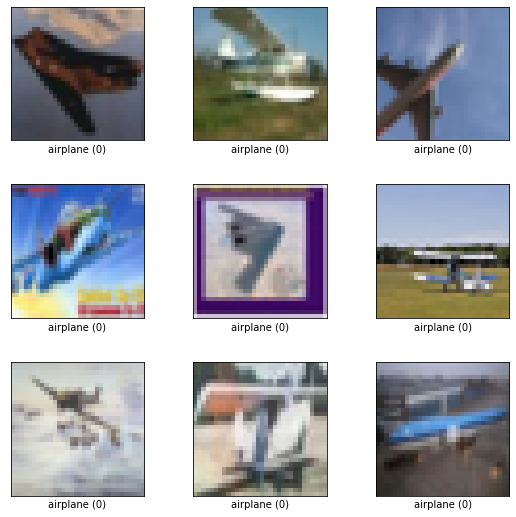

In [8]:
#@title ShowExamplesofDatasetAirplanes
## Tfds.show_examples is a matplotlib funnction that only works on image ds's, and you have to pass it the "info" for some reason
fig = tfds.show_examples(dataset_airplanes, info)

How to display one picture of a dataset using `next(iter(dataset)`

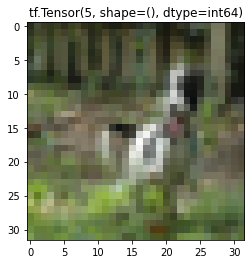

In [9]:
#@title ShowExampleofOneIterations of DatasetDogs
# I wish I could display ID!!

img, label = next(iter(dataset_dogs))
plt.title(str(label))
plt.imshow(img)

#0x7f6e309eff10?


# Create validation set of 10,000 images

In [10]:
#@title
# I want 10 un replicated samples from dataset_airplanes + dataset_automobiles... dataset_trucks.

# There are 5000 images of each Class 
# I want 10 equal sets A, B, C, D, ... J plus a validation set
# I want 10,000 total images in the validation set with 1000 of each class
# and I want 10 sets of training images  4000 total images, so 400 images in each class

N = 1000
dataset_airplanes_val   = dataset_airplanes.take(N)
dataset_automobiles_val  = dataset_automobiles.take(N)
dataset_birds_val       = dataset_birds.take(N)  
dataset_cats_val        = dataset_cats.take(N)
dataset_deers_val       = dataset_deers.take(N)
dataset_dogs_val        = dataset_dogs.take(N)
dataset_frogs_val       = dataset_frogs.take(N)
dataset_horses_val      = dataset_horses.take(N)
dataset_ships_val       = dataset_ships.take(N)
dataset_trucks_val      = dataset_trucks.take(N)


# Make sure to skip the next 1000 images in each data set before making training set
dataset_airplanes   = dataset_airplanes.skip(N)
dataset_automobiles  = dataset_automobiles.skip(N)
dataset_birds      = dataset_birds.skip(N)  
dataset_cats        = dataset_cats.skip(N)
dataset_deers       = dataset_deers.skip(N)
dataset_dogs        = dataset_dogs.skip(N)
dataset_frogs       = dataset_frogs.skip(N)
dataset_horses      = dataset_horses.skip(N)
dataset_ships       = dataset_ships.skip(N)
dataset_trucks      = dataset_trucks.skip(N)

# # Check that remaining dataset does not have validation data
# fig = tfds.show_examples(dataset_ships, info)
# fig = tfds.show_examples(dataset_ships_val, info)
# # I checked and they dont.


# NOW, How do I combine my val sets?

# Hint1 its not this... 
# val = dataset_airplanes_val + dataset_automobile_val + dataset_birds_val

# #  Hint2 its also not this implementation of zip because the info file doesn't match it
# val = tf.data.Dataset.zip((dataset_airplanes_val,
#                     dataset_automobile_val,
#                     dataset_birds_val,
#                     dataset_cats_val,
#                     dataset_deers_val,
#                     dataset_dogs_val,
#                     dataset_frogs_val,
#                     dataset_horses_val,
#                     dataset_ships_val,
#                     dataset_trucks_val ))
 
# fig = tfds.show_examples(val, info)   # Returns a warning that the info file is not compatible


# is it concatenate? YESSSSSSSSSSSSSSSSSSSSSS
val = dataset_airplanes_val.concatenate(dataset_automobiles_val)
# This is how I checked that it worked
# fig = tfds.show_examples(val.skip(999), info)    # shows 1 airplane and then 8 automobiles

val = val.concatenate(dataset_birds_val)
val = val.concatenate(dataset_cats_val)
val = val.concatenate(dataset_deers_val)
val = val.concatenate(dataset_dogs_val)
val = val.concatenate(dataset_frogs_val)
val = val.concatenate(dataset_horses_val)
val = val.concatenate(dataset_ships_val)
val = val.concatenate(dataset_trucks_val)
  
# print(val.reduce(np.int32(0), lambda x,_ : x + 1))  # this shows 10000! Thank goodness! :-)



# Create smaller groups of each CIFAR Class sets (set Shard)

After removing the 10,000 validation set from the training-data, the remaining set has 40,000 images, 4000 images of each class.  To create smaller training-datasets of similar sizes, shard the dataset into equal pieces.

For the initial days of testing I decided on **250 images** per class for my first couple runs, which equates to 16 shards (40,000/16 = 250) .  When I wanted to study what was going on more beneath the hood for my augmentations, I decided to make the training set even more tiny so I could view all the images per training set I decided to try 1 image per class so I could easily view all the images augmeted and not augmented.  This meant I needed **4000 shards!** for troubleshooting.



In [11]:
SHARDS=16

#### Airplanes (airplanes_A, ... airplanes_P)

In [12]:
#@title
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shard

# Check that each of the remaining 10 datasets has only 4000 images 
# print(dataset_airplanes.reduce(np.int32(0), lambda x,_ : x + 1))  # 4000 check!

# Shard each of the remaining 10 datasets into 16 smaller groups
airplanes_A = dataset_airplanes.shard(num_shards=SHARDS, index = 0)
airplanes_B = dataset_airplanes.shard(num_shards=SHARDS, index = 1)
airplanes_C = dataset_airplanes.shard(num_shards=SHARDS, index = 2)
airplanes_D = dataset_airplanes.shard(num_shards=SHARDS, index = 3)
airplanes_E = dataset_airplanes.shard(num_shards=SHARDS, index = 4)
airplanes_F = dataset_airplanes.shard(num_shards=SHARDS, index = 5)
airplanes_G = dataset_airplanes.shard(num_shards=SHARDS, index = 6)
airplanes_H = dataset_airplanes.shard(num_shards=SHARDS, index = 7)
airplanes_I = dataset_airplanes.shard(num_shards=SHARDS, index = 8)
airplanes_J = dataset_airplanes.shard(num_shards=SHARDS, index = 9)
airplanes_K = dataset_airplanes.shard(num_shards=SHARDS, index = 10)
airplanes_L = dataset_airplanes.shard(num_shards=SHARDS, index = 11)
airplanes_M = dataset_airplanes.shard(num_shards=SHARDS, index = 12)
airplanes_N = dataset_airplanes.shard(num_shards=SHARDS, index = 13)
airplanes_O = dataset_airplanes.shard(num_shards=SHARDS, index = 14)
airplanes_P = dataset_airplanes.shard(num_shards=SHARDS, index = 15)

#check that a random airplane dataset only has 250 images
# print(airplanes_M.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


#### Automobiles

In [13]:
#@title
# dataset_automobile

# Check that each of the remaining 10 datasets has only 4000 images 
# print(dataset_automobile.reduce(np.int32(0), lambda x,_ : x + 1))  # 4000 check!

# Shard each of the remaining 10 datasets into 16 smaller groups
automobiles_A = dataset_automobiles.shard(num_shards=SHARDS, index = 0)
automobiles_B = dataset_automobiles.shard(num_shards=SHARDS, index = 1)
automobiles_C = dataset_automobiles.shard(num_shards=SHARDS, index = 2)
automobiles_D = dataset_automobiles.shard(num_shards=SHARDS, index = 3)
automobiles_E = dataset_automobiles.shard(num_shards=SHARDS, index = 4)
automobiles_F = dataset_automobiles.shard(num_shards=SHARDS, index = 5)
automobiles_G = dataset_automobiles.shard(num_shards=SHARDS, index = 6)
automobiles_H = dataset_automobiles.shard(num_shards=SHARDS, index = 7)
automobiles_I = dataset_automobiles.shard(num_shards=SHARDS, index = 8)
automobiles_J = dataset_automobiles.shard(num_shards=SHARDS, index = 9)
automobiles_K = dataset_automobiles.shard(num_shards=SHARDS, index = 10)
automobiles_L = dataset_automobiles.shard(num_shards=SHARDS, index = 11)
automobiles_M = dataset_automobiles.shard(num_shards=SHARDS, index = 12)
automobiles_N = dataset_automobiles.shard(num_shards=SHARDS, index = 13)
automobiles_O = dataset_automobiles.shard(num_shards=SHARDS, index = 14)
automobiles_P = dataset_automobiles.shard(num_shards=SHARDS, index = 15)


#check that a random airplane dataset only has 250 images
# print(airplanes_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Birds

In [14]:
#@title
# dataset_birds

# Shard each of the remaining 10 datasets into 16 smaller groups
birds_A = dataset_birds.shard(num_shards=SHARDS, index = 0)
birds_B = dataset_birds.shard(num_shards=SHARDS, index = 1)
birds_C = dataset_birds.shard(num_shards=SHARDS, index = 2)
birds_D = dataset_birds.shard(num_shards=SHARDS, index = 3)
birds_E = dataset_birds.shard(num_shards=SHARDS, index = 4)
birds_F = dataset_birds.shard(num_shards=SHARDS, index = 5)
birds_G = dataset_birds.shard(num_shards=SHARDS, index = 6)
birds_H = dataset_birds.shard(num_shards=SHARDS, index = 7)
birds_I = dataset_birds.shard(num_shards=SHARDS, index = 8)
birds_J = dataset_birds.shard(num_shards=SHARDS, index = 9)
birds_K = dataset_birds.shard(num_shards=SHARDS, index = 10)
birds_L = dataset_birds.shard(num_shards=SHARDS, index = 11)
birds_M = dataset_birds.shard(num_shards=SHARDS, index = 12)
birds_N = dataset_birds.shard(num_shards=SHARDS, index = 13)
birds_O = dataset_birds.shard(num_shards=SHARDS, index = 14)
birds_P = dataset_birds.shard(num_shards=SHARDS, index = 15)

#check that a random airplane dataset only has 250 images
# print(airplanes_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Cats

In [15]:
#@title
# dataset_cats

# Shard each of the remaining 10 datasets into 16 smaller groups
cats_A = dataset_cats.shard(num_shards=SHARDS, index = 0)
cats_B = dataset_cats.shard(num_shards=SHARDS, index = 1)
cats_C = dataset_cats.shard(num_shards=SHARDS, index = 2)
cats_D = dataset_cats.shard(num_shards=SHARDS, index = 3)
cats_E = dataset_cats.shard(num_shards=SHARDS, index = 4)
cats_F = dataset_cats.shard(num_shards=SHARDS, index = 5)
cats_G = dataset_cats.shard(num_shards=SHARDS, index = 6)
cats_H = dataset_cats.shard(num_shards=SHARDS, index = 7)
cats_I = dataset_cats.shard(num_shards=SHARDS, index = 8)
cats_J = dataset_cats.shard(num_shards=SHARDS, index = 9)
cats_K = dataset_cats.shard(num_shards=SHARDS, index = 10)
cats_L = dataset_cats.shard(num_shards=SHARDS, index = 11)
cats_M = dataset_cats.shard(num_shards=SHARDS, index = 12)
cats_N = dataset_cats.shard(num_shards=SHARDS, index = 13)
cats_O = dataset_cats.shard(num_shards=SHARDS, index = 14)
cats_P = dataset_cats.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(cats_P.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Deer(s)

In [16]:
#@title
# dataset_deers
# Shard each of the remaining 10 datasets into 16 smaller groups
deers_A = dataset_deers.shard(num_shards=SHARDS, index = 0)
deers_B = dataset_deers.shard(num_shards=SHARDS, index = 1)
deers_C = dataset_deers.shard(num_shards=SHARDS, index = 2)
deers_D = dataset_deers.shard(num_shards=SHARDS, index = 3)
deers_E = dataset_deers.shard(num_shards=SHARDS, index = 4)
deers_F = dataset_deers.shard(num_shards=SHARDS, index = 5)
deers_G = dataset_deers.shard(num_shards=SHARDS, index = 6)
deers_H = dataset_deers.shard(num_shards=SHARDS, index = 7)
deers_I = dataset_deers.shard(num_shards=SHARDS, index = 8)
deers_J = dataset_deers.shard(num_shards=SHARDS, index = 9)
deers_K = dataset_deers.shard(num_shards=SHARDS, index = 10)
deers_L = dataset_deers.shard(num_shards=SHARDS, index = 11)
deers_M = dataset_deers.shard(num_shards=SHARDS, index = 12)
deers_N = dataset_deers.shard(num_shards=SHARDS, index = 13)
deers_O = dataset_deers.shard(num_shards=SHARDS, index = 14)
deers_P = dataset_deers.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(deers_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

In [17]:
#@title


In [18]:
#@title


#### Dogs

In [19]:
#@title
# dataset_dogs
# Shard each of the remaining 10 datasets into 16 smaller groups
dogs_A = dataset_dogs.shard(num_shards=SHARDS, index = 0)
dogs_B = dataset_dogs.shard(num_shards=SHARDS, index = 1)
dogs_C = dataset_dogs.shard(num_shards=SHARDS, index = 2)
dogs_D = dataset_dogs.shard(num_shards=SHARDS, index = 3)
dogs_E = dataset_dogs.shard(num_shards=SHARDS, index = 4)
dogs_F = dataset_dogs.shard(num_shards=SHARDS, index = 5)
dogs_G = dataset_dogs.shard(num_shards=SHARDS, index = 6)
dogs_H = dataset_dogs.shard(num_shards=SHARDS, index = 7)
dogs_I = dataset_dogs.shard(num_shards=SHARDS, index = 8)
dogs_J = dataset_dogs.shard(num_shards=SHARDS, index = 9)
dogs_K = dataset_dogs.shard(num_shards=SHARDS, index = 10)
dogs_L = dataset_dogs.shard(num_shards=SHARDS, index = 11)
dogs_M = dataset_dogs.shard(num_shards=SHARDS, index = 12)
dogs_N = dataset_dogs.shard(num_shards=SHARDS, index = 13)
dogs_O = dataset_dogs.shard(num_shards=SHARDS, index = 14)
dogs_P = dataset_dogs.shard(num_shards=SHARDS, index = 15)

#check that a random airplane dataset only has 250 images
# print(dogs_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


#### Frogs

In [20]:
#@title
# dataset_frogs
# Shard each of the remaining 10 datasets into 16 smaller groups
frogs_A = dataset_frogs.shard(num_shards=SHARDS, index = 0)
frogs_B = dataset_frogs.shard(num_shards=SHARDS, index = 1)
frogs_C = dataset_frogs.shard(num_shards=SHARDS, index = 2)
frogs_D = dataset_frogs.shard(num_shards=SHARDS, index = 3)
frogs_E = dataset_frogs.shard(num_shards=SHARDS, index = 4)
frogs_F = dataset_frogs.shard(num_shards=SHARDS, index = 5)
frogs_G = dataset_frogs.shard(num_shards=SHARDS, index = 6)
frogs_H = dataset_frogs.shard(num_shards=SHARDS, index = 7)
frogs_I = dataset_frogs.shard(num_shards=SHARDS, index = 8)
frogs_J = dataset_frogs.shard(num_shards=SHARDS, index = 9)
frogs_K = dataset_frogs.shard(num_shards=SHARDS, index = 10)
frogs_L = dataset_frogs.shard(num_shards=SHARDS, index = 11)
frogs_M = dataset_frogs.shard(num_shards=SHARDS, index = 12)
frogs_N = dataset_frogs.shard(num_shards=SHARDS, index = 13)
frogs_O = dataset_frogs.shard(num_shards=SHARDS, index = 14)
frogs_P = dataset_frogs.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(frogs_A.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Horses

In [21]:
#@title
# dataset_horses
# Shard each of the remaining 10 datasets into 16 smaller groups
horses_A = dataset_horses.shard(num_shards=SHARDS, index = 0)
horses_B = dataset_horses.shard(num_shards=SHARDS, index = 1)
horses_C = dataset_horses.shard(num_shards=SHARDS, index = 2)
horses_D = dataset_horses.shard(num_shards=SHARDS, index = 3)
horses_E = dataset_horses.shard(num_shards=SHARDS, index = 4)
horses_F = dataset_horses.shard(num_shards=SHARDS, index = 5)
horses_G = dataset_horses.shard(num_shards=SHARDS, index = 6)
horses_H = dataset_horses.shard(num_shards=SHARDS, index = 7)
horses_I = dataset_horses.shard(num_shards=SHARDS, index = 8)
horses_J = dataset_horses.shard(num_shards=SHARDS, index = 9)
horses_K = dataset_horses.shard(num_shards=SHARDS, index = 10)
horses_L = dataset_horses.shard(num_shards=SHARDS, index = 11)
horses_M = dataset_horses.shard(num_shards=SHARDS, index = 12)
horses_N = dataset_horses.shard(num_shards=SHARDS, index = 13)
horses_O = dataset_horses.shard(num_shards=SHARDS, index = 14)
horses_P = dataset_horses.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(horses_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Ships

In [22]:
#@title
# dataset_ships
# Shard each of the remaining 10 datasets into 16 smaller groups
ships_A = dataset_ships.shard(num_shards=SHARDS, index = 0)
ships_B = dataset_ships.shard(num_shards=SHARDS, index = 1)
ships_C = dataset_ships.shard(num_shards=SHARDS, index = 2)
ships_D = dataset_ships.shard(num_shards=SHARDS, index = 3)
ships_E = dataset_ships.shard(num_shards=SHARDS, index = 4)
ships_F = dataset_ships.shard(num_shards=SHARDS, index = 5)
ships_G = dataset_ships.shard(num_shards=SHARDS, index = 6)
ships_H = dataset_ships.shard(num_shards=SHARDS, index = 7)
ships_I = dataset_ships.shard(num_shards=SHARDS, index = 8)
ships_J = dataset_ships.shard(num_shards=SHARDS, index = 9)
ships_K = dataset_ships.shard(num_shards=SHARDS, index = 10)
ships_L = dataset_ships.shard(num_shards=SHARDS, index = 11)
ships_M = dataset_ships.shard(num_shards=SHARDS, index = 12)
ships_N = dataset_ships.shard(num_shards=SHARDS, index = 13)
ships_O = dataset_ships.shard(num_shards=SHARDS, index = 14)
ships_P = dataset_ships.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(ships_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Trucks


In [23]:
#@title
# dataset_trucks
# Shard each of the remaining 10 datasets into 16 smaller groups
trucks_A = dataset_trucks.shard(num_shards=SHARDS, index = 0)
trucks_B = dataset_trucks.shard(num_shards=SHARDS, index = 1)
trucks_C = dataset_trucks.shard(num_shards=SHARDS, index = 2)
trucks_D = dataset_trucks.shard(num_shards=SHARDS, index = 3)
trucks_E = dataset_trucks.shard(num_shards=SHARDS, index = 4)
trucks_F = dataset_trucks.shard(num_shards=SHARDS, index = 5)
trucks_G = dataset_trucks.shard(num_shards=SHARDS, index = 6)
trucks_H = dataset_trucks.shard(num_shards=SHARDS, index = 7)
trucks_I = dataset_trucks.shard(num_shards=SHARDS, index = 8)
trucks_J = dataset_trucks.shard(num_shards=SHARDS, index = 9)
trucks_K = dataset_trucks.shard(num_shards=SHARDS, index = 10)
trucks_L = dataset_trucks.shard(num_shards=SHARDS, index = 11)
trucks_M = dataset_trucks.shard(num_shards=SHARDS, index = 12)
trucks_N = dataset_trucks.shard(num_shards=SHARDS, index = 13)
trucks_O = dataset_trucks.shard(num_shards=SHARDS, index = 14)
trucks_P = dataset_trucks.shard(num_shards=SHARDS, index = 15)


#check that a random airplane dataset only has 250 images
# print(trucks_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


# Concatenate the smaller CIFAR classes sets into 10 independent small  training Groups: 

This is the `train_A`, `train_B`, `train_C`... `train_J`  datasets of 1 image each class, 10 images total, currently ao 11/10/21. and will be updated to  whatever the current SHARD is later

#### Group A  (train_A)

In [24]:
#@title
# {A}
X = birds_A, cats_A, deers_A, dogs_A, frogs_A, horses_A, ships_A, trucks_A
train_A = airplanes_A.concatenate(automobiles_A)

for i in list(X):
  train_A = train_A.concatenate(i) 

print(train_A.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

tf.Tensor(2500, shape=(), dtype=int32)


#### Group B

In [25]:
#@title
# {B}
X = birds_B, cats_B, deers_B, dogs_B, frogs_B, horses_B, ships_B, trucks_B
train_B = airplanes_B.concatenate(automobiles_B)

for i in list(X):
  train_B = train_B.concatenate(i)

# print(train_B.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group C

In [26]:
#@title
# {C}
X = birds_C, cats_C, deers_C, dogs_C, frogs_C, horses_C, ships_C, trucks_C
train_C = airplanes_C.concatenate(automobiles_C)

for i in list(X):
  train_C = train_C.concatenate(i)

# print(train_C.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group D

In [27]:
#@title
# {D}
X = birds_D, cats_D, deers_D, dogs_D, frogs_D, horses_D, ships_D, trucks_D
train_D = airplanes_D.concatenate(automobiles_D)

for i in list(X):
  train_D = train_D.concatenate(i)

# print(train_D.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group E

In [28]:
#@title
# {E}
X = birds_E, cats_E, deers_E, dogs_E, frogs_E, horses_E, ships_E, trucks_E
train_E = airplanes_E.concatenate(automobiles_E)

for i in list(X):
  train_E = train_E.concatenate(i)

# print(train_E.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group F

In [29]:
#@title
# {F}
X = birds_F, cats_F, deers_F, dogs_F, frogs_F, horses_F, ships_F, trucks_F
train_F = airplanes_F.concatenate(automobiles_F)

for i in list(X):
  train_F = train_F.concatenate(i)

# print(train_F.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group G

In [30]:
#@title
# {G}
X = birds_G, cats_G, deers_G, dogs_G, frogs_G, horses_G, ships_G, trucks_G
train_G = airplanes_G.concatenate(automobiles_G)

for i in list(X):
  train_G = train_G.concatenate(i)

# print(train_G.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group H

In [31]:
#@title
# {H}
X = birds_H, cats_H, deers_H, dogs_H, frogs_H, horses_H, ships_H, trucks_H
train_H = airplanes_H.concatenate(automobiles_H)

for i in list(X):
  train_H = train_H.concatenate(i)

# print(train_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group I

In [32]:
#@title
# {I}
X = birds_I, cats_I, deers_I, dogs_I, frogs_I, horses_I, ships_I, trucks_I
train_I = airplanes_I.concatenate(automobiles_I)

for i in list(X):
  train_I = train_I.concatenate(i)

# print(train_I.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group J

In [33]:
#@title
# {J}
X = birds_J, cats_J, deers_J, dogs_J, frogs_J, horses_J, ships_J, trucks_J
train_J = airplanes_J.concatenate(automobiles_J)

for i in list(X):
  train_J = train_J.concatenate(i)

# print(train_J.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

Testing out whether I can see IDs again...

I added some code before the lines to load dataset, they are as follows#
from https://www.tensorflow.org/datasets/api_docs/python/tfds/load#args
and https://www.tensorflow.org/datasets/determinism



> read_config code added


```
read_config = tfds.ReadConfig(shuffle_seed=seed) 
read_config.add_tfds_id = True
dataset, info = tfds.load('cifar10', as_supervised=True, with_info=True, read_config=read_config)
```


I want to make sure the rest of my scripts run fine before any more tinkering!

In [34]:
# # I believe I need to define the shuffle number for the Train_A set by using the total number of images in it, not just an arbitrarily large number?
# # count = count_images(train_A)
# # unbatch_train_A = (tf.data.Dataset.unbatch(train_A))
# # count = count_images(unbatch_train_A)

# #this changes everytime i run it

# # for id, img, label in unbatch_train_A:
# #   print(label)  # this appears to be the labels of the image in unbatchtrain_A (7, 6, 4, 2, 1, 3, 9, 5, 8, 0)
# #   #print(img)  # these are each of the images 32*32*3
# #   print(id)
 
# tfds.as_dataframe(dataset.take(5), info)  #it doesn't look like IDS is being returned in info

# print(info)


### Adding Batches, Buffers, Shuffles and Caches to Val, Test, and Train_A

The following is necessary to run the datasets through the CNN models  Do not run the following more than once because it'll try to make an additional "batch" dimension in your datasets

The result of running `print(info)`:

> CIFAR10 Info
```
tfds.core.DatasetInfo(    
    name='cifar10',
    version=3.0.2,    
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',   
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',   
    features=FeaturesDict({   
        'id': Text(shape=(), dtype=tf.string),   
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),   
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),   
    }),   
    total_num_examples=60000,   
    splits={   
        'test': 10000,   
        'train': 50000,   
    },   
    supervised_keys=('image', 'label'),   
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,   
        author = {Alex Krizhevsky},   
        title = {Learning multiple layers of features from tiny images},   
        institution = {},  
        year = {2009}   
    }""",   
    redistribution_info=,   
)
```
 




In [35]:
#@title

train_A_shuffle_num = 2500
tran_A_batch_num    = 100

if initial_run == 0: 
    
  # AUTOTUNE = tf.data.AUTOTUNE # results in -1 which i think is code for the whole database
  train_A = train_A.cache().prefetch(buffer_size=AUTOTUNE)
  train_A = train_A.shuffle(train_A_shuffle_num, reshuffle_each_iteration=False)  #, seed=seed)
  train_A = train_A.batch(tran_A_batch_num)  

  val = val.cache().prefetch(buffer_size=AUTOTUNE)
  val = val.batch(100)

  x_test = x_test.cache().prefetch(AUTOTUNE)
  x_test = x_test.batch(500)

else:
  pass

initial_run = initial_run+1

#### Time required to create datasets:  

In [36]:

toc = time.time()  
print(f"Made datasets in {toc - tic:0.4f} seconds")
!mkdir -p saved_model


Made datasets in 88.2340 seconds


Get min-max values of dataset to see whata the range is

In [37]:

def get_min_max(tfdata, text):
  print(str(text), "is ", tfdata)
  image, _ = next(iter(tfdata))
  print("test")
  print(np.min(image[0]), np.max(image[0]), "\n")


# I've decided to hide the following code, which was merely to let me see what the range of the pixel values were, and it was usually around 2-253 or so
# get_min_max(train_A, "train_A")
# get_min_max(x_test, "x_test")
# get_min_max(val, "val")



# Build CNN 

## Train the model function :


In [ ]:
#@title Make a Vanilla CNN Function { form-width: "20px" }
# Make a Vanilla CNN
# One thing I'd like to add is residual connections, as Cholet mentions that is a standard practice in computer vision


def makemodel(DROPOUT):  #returns model
  num_classes = 10
  input_shape = (32, 32, 3)

  # For Reference these are the defaults
  # kernel_initializer="glorot_uniform",
  # bias_initializer="zeros",
  # padding="valid",  #valid = no padding
  # kernel_regularizer=None,
  # bias_regularizer=None,
  # activity_regularizer=None,

  initializer = tf.keras.initializers.HeUniform(seed)  #this alows the model to start from the same weights each time

  model = tf.keras.Sequential(
  [
      #keras.Input(),
      tf.keras.Input(shape=input_shape),

      layers.experimental.preprocessing.Rescaling(1./255),
      #data_augmentation,   
      layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer1"),
      layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool1"),
      layers.BatchNormalization(name="BN1"),
   
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer2"),
      layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool2"),
      layers.BatchNormalization(name="BN2"),
   
      layers.Conv2D(128, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer3"),
      layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool3"),
      layers.BatchNormalization(name="BN3"),
   
      layers.Flatten(),
      layers.Dropout(DROPOUT),
      layers.Dense(512, activation="relu", kernel_initializer=initializer),
      layers.Dropout(DROPOUT),
      layers.Dense(num_classes, activation="softmax")

  ])


  model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])  #changed, added to val_accuracy

  print("Dropout is: ", DROPOUT)
  model.save_weights('saved_model/blank_model')  # Enables a fresh-restart between runs
  model.load_weights('saved_model/blank_model')

  return model

# -----------------------------------------

# I need to understand tf.function better 
# @tf.function

def trainmodel(MODEL, TRAININGDATA):   # returns TRAINEDMODEL

  history = MODEL.fit(
    TRAININGDATA,
    validation_data=(val),
    epochs=100,
    callbacks = keras.callbacks.EarlyStopping(monitor= 'val_loss', patience=15, restore_best_weights=True), 
    verbose=0 # 
  )

  #I've entered show plot-loss twice to force another plot to move down the screen
  #this code would be improved if i could simply make this appear under /
  # the view_images command that displays 10 to 20 images


  # # summarize history for loss
  # x = 0
  # y = 0
  # plt.plot(x)
  # plt.plot(y)
  # plt.show()
 

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  val_acc_array = history.history['val_accuracy']
  val_loss_array = history.history['val_loss']

  n_epochs_best = np.argmax(val_acc_array)
  n_epochs_bestloss = np.argmin(val_loss_array)
  print("Early-Stop is on Val-Loss with patience = 15")

  
  
  print("Early Stop Epoch was: ", n_epochs_bestloss, "when  Val Loss was: ", np.min(val_loss_array), ", and Val Acc happened to be", val_acc_array[n_epochs_bestloss])
  print("Additionally, the best val acc epoch happened to be ", n_epochs_best, "when val acc was: ",  val_acc_array[n_epochs_best], "and Val Loss happened to be ",  val_loss_array[n_epochs_best] )
  if (n_epochs_bestloss > 90) or (n_epochs_best >90 ) :
    print("This is a pretty high epoch number! ********************************")

  # model.save('saved_model/my_model')




  return MODEL



# Transition to Augmentations


In [96]:
#@title Augmentations Timer

start_augmentations = time.time()

## Prepare the Google Colab environment for Albumentations



#### Install the latest version of Albumentations

Google Colab has an outdated version of Albumentations so we will install the latest stable version from PyPi.

In [97]:
#@title  instal augmentations
# !pip install -q -U albumentations
# !echo "$(pip freeze | grep albumentations) is successfully installed"

!pip install -U git+https://github.com/albumentations-team/albumentations -q
# necessary imports
from functools import partial
import albumentations as A
import cv2 as cv2

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE


## Define Augmentation Factors' Order and Levels

The following are 21 factors: 20 data-augmentation techniques and one regularization factor "*Dropout*" Percent Level, to compare with.  The order is what seemed to give each factor the most opportunity to add to the image, and more "destructive" factors were ordered later, like "ToGray" and Crop or ZoomIn since they take away image data permanently.  Zoom Out was order 11 because I wanted to make sure noise, blur, zoom, sharpen, contrast, did not have a over-magnified effect if after ZoomOut.  FlipHorizontal and FlipVertical are at the bottom not because they are destructive, but because I wanted to keep the categorical variables grouped as much as possible for consistent coding practices.

|Order | Factors | Role | Low | High |
| -: | :- | :-: | :-: | :-: |
1|*dropout*|Continuous|0.4  |0.6
2|shiftX|Continuous|0 | 0.1
3|shiftY|Continuous|0|  0.1
4|noise|Continuous|0  |24
5|blur|Continuous|0 | 7**
6|sharpen|Continuous|0 | 0.1
7|contrast|Continuous|0 | 0.2
8|brighten|Continuous|0|  0.2
9|darken (negative brightness)|Continuous|0 | -0.2 *
10|gamma|Continuous|100|  120
11|zoomOut (negative zoomin) |Continuous| 0 | -0.16*
12|rotate|Continuous|0|  14
13|crop|Continuous|32* | 24*
14|zoomin|Continuous|0  |0.16
15|flipH|Categorical|0 | 1
16|flipV|Categorical|0 | 1
17|fancyPCA|Categorical|0 | 1
18|equalize|Categorical|0 | 1
19|channelShuffle|Categorical|0 | 1
20|elasticTransform|Categorical|0 | 1
21|togray|Categorical|0 | 1

* Values with asterisks are for emphasis since they seem counterintuitive

** Blur values can only be odd so a center point will be rounded down from 3.5 to 3 - four center points were changed

A 50-run definitive screening design with 2 blocks is used to see which main effects are most important.  The JMP Metrics for this design are below:

 | Definitive Screening Design Diagnostics  | | 
| --- | --- | 
 | D Efficiency| 92.46019| 
| G Efficiency | 81.68744 | 
| A Efficiency | 91.32396 | 
| Average Variance of Prediction	 | 0.298038 |


## Define Randomized Definitive Screening Design 

**Block 1**
 
 xRun|Block|dropout|shiftX|shiftY|noise|blur|sharpen|contrast|brighten|darken|gamma|zoomOut|rotate|crop|zoomin|flipH|flipV|fancyPCA|equalize|channelShuffle|elasticTransform|togray
:-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-
1|1|0.4|0.1|0|24|7|0.1|0.2|0.2|-0.2|100|-0.08|14|24|0.16|1|1|0|1|0|1|0
2|1|0.4|0.1|0|24|7|0|0|0|0|100|-0.16|0|32|0|1|1|1|1|1|1|0
3|1|0.5|0|0|24|7|0.1|0|0.2|-0.2|100|-0.16|14|32|0.16|0|0|0|0|1|0|1
4|1|0.4|0|0.1|24|3|0.1|0|0|-0.2|100|0|0|32|0|1|1|0|0|0|1|1
5|1|0.6|0|0|0|0|0|0.2|0.2|-0.2|100|0|0|32|0.16|1|1|1|0|1|0|0
6|1|0.6|0.1|0|24|0|0.1|0.2|0|-0.2|120|-0.16|0|24|0.08|1|0|1|0|0|1|1
7|1|0.4|0|0|0|7|0|0.2|0.2|0|120|0|7|24|0|0|1|0|0|0|1|1
8|1|0.4|0.1|0.1|0|0|0.1|0.2|0.2|-0.2|100|0|0|32|0|0|0|1|1|1|1|1
9|1|0.6|0|0|24|7|0|0|0|0|120|-0.16|14|24|0.16|1|1|0|0|0|0|0
10|1|0.5|0.05|0.05|12|3|0.05|0.1|0.1|-0.1|110|-0.08|7|28|0.08|0|0|0|0|0|0|0
11|1|0.4|0|0|24|7|0.1|0.2|0.1|-0.2|120|0|0|24|0|0|0|1|1|1|0|0
12|1|0.4|0.1|0.1|24|0|0|0.2|0.2|-0.2|120|-0.16|0|32|0.16|0|1|0|1|0|0|0
13|1|0.6|0|0|0|7|0.1|0|0|0|100|0|14|24|0|1|0|1|0|1|1|1
14|1|0.6|0.05|0.1|24|7|0.1|0.2|0.2|0|120|0|14|32|0.16|1|1|1|1|1|1|1
15|1|0.4|0|0|0|7|0|0|0.2|-0.2|120|-0.16|0|32|0.16|1|0|1|1|0|1|1
16|1|0.4|0.05|0|0|0|0|0|0|-0.2|100|-0.16|0|24|0|0|0|0|0|0|0|0
17|1|0.4|0.1|0.1|24|7|0.1|0|0|0|120|-0.16|14|24|0|0|0|0|1|0|1|1
18|1|0.6|0.1|0.1|24|0|0.1|0|0|-0.2|100|-0.16|7|32|0.16|1|0|1|1|1|0|0
19|1|0.6|0|0.1|0|0|0|0|0|0|120|-0.08|0|32|0|0|0|1|0|1|0|1
20|1|0.6|0|0.1|0|0|0.1|0.2|0.2|-0.2|120|0|14|24|0.16|0|0|0|0|0|0|1
21|1|0.6|0.1|0.1|0|0|0|0|0.1|0|100|-0.16|14|32|0.16|1|1|0|0|0|1|1
22|1|0.5|0.05|0.05|12|3|0.05|0.1|0.1|-0.1|110|-0.08|7|28|0.08|1|1|1|1|1|1|1
23|1|0.6|0.1|0.1|24|0|0.1|0.2|0|0|100|0|14|24|0|0|1|0|0|1|0|0
24|1|0.6|0.1|0|0|3|0|0.2|0.2|0|120|-0.16|14|24|0.16|0|0|1|1|1|0|0
25|1|0.5|0.1|0.1|0|0|0|0.2|0|0|120|0|0|24|0|1|1|1|1|0|1|0
26|1|0.4|0|0.1|0|7|0|0|0.2|0|100|0|14|32|0.08|0|1|0|1|1|0|0


**Block 2**

xRun|Block|dropout|shiftX|shiftY|noise|blur|sharpen|contrast|brighten|darken|gamma|zoomOut|rotate|crop|zoomin|flipH|flipV|fancyPCA|equalize|channelShuffle|elasticTransform|togray
:-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-
27|2|0.6|0.1|0|12|6|0.1|0.2|0.2|0|100|-0.16|0|32|0|0|1|1|0|0|0|1
28|2|0.6|0.1|0|0|6|0|0.2|0|-0.2|100|0|14|32|0|1|0|0|1|0|0|1
29|2|0.4|0|0|24|0|0.05|0.2|0|0|100|0|14|32|0.16|0|0|1|0|0|1|0
30|2|0.6|0.1|0|24|0|0|0|0.2|0|100|0|0|24|0.16|0|0|0|1|1|1|1
31|2|0.6|0|0.1|24|6|0|0.2|0.2|-0.1|100|-0.16|0|24|0|1|0|0|0|1|1|0
32|2|0.6|0|0.1|24|6|0|0.1|0|-0.2|100|0|0|24|0.16|0|1|1|1|0|0|1
33|2|0.4|0.1|0.1|0|6|0|0.2|0|-0.2|100|-0.16|14|24|0.16|0|1|1|0|1|1|1
34|2|0.4|0|0.1|0|6|0.1|0.2|0|-0.2|120|-0.16|14|32|0|1|1|1|0|0|0|0
35|2|0.4|0.1|0.05|24|6|0|0.2|0|0|120|0|0|32|0.16|1|0|0|0|1|0|1
36|2|0.6|0|0|24|0|0.1|0|0.2|0|120|0|0|32|0|1|0|0|1|0|0|0
37|2|0.6|0.1|0.1|24|6|0|0|0.2|-0.2|120|0|14|32|0|0|0|1|0|0|1|0
38|2|0.6|0|0.1|0|6|0.1|0.2|0|0|110|-0.16|0|32|0.16|0|0|0|1|0|1|0
39|2|0.6|0|0.05|0|0|0.1|0|0.2|-0.2|100|-0.16|14|24|0|0|1|1|1|0|1|0
40|2|0.4|0|0.1|12|0|0|0|0|-0.2|120|0|14|24|0.16|1|0|0|1|1|1|0
41|2|0.6|0.1|0.1|0|6|0.05|0|0.2|-0.2|120|-0.16|0|24|0|1|1|0|1|1|0|1
42|2|0.4|0|0.1|24|0|0.1|0|0.2|0|120|-0.16|0|24|0.16|0|1|1|0|1|1|0
43|2|0.4|0.1|0|0|0|0.1|0.1|0.2|0|120|-0.16|14|32|0|1|0|0|0|1|1|0
44|2|0.4|0|0|0|0|0.1|0.2|0|0|100|-0.16|0|24|0.16|1|1|0|1|1|0|1
45|2|0.4|0.1|0|0|0|0.1|0|0|-0.1|120|0|14|32|0.16|0|1|1|1|0|0|1
46|2|0.4|0.1|0.1|0|6|0.1|0|0.2|0|100|0|0|24|0.16|1|0|1|0|0|0|0
47|2|0.4|0|0.1|24|0|0|0.2|0.2|0|100|-0.16|14|28|0|1|0|1|1|0|0|1
48|2|0.4|0.1|0|24|0|0|0|0.2|-0.2|110|0|14|24|0|1|1|1|0|1|0|1
49|2|0.6|0.1|0|0|6|0.1|0|0|-0.2|120|0|0|28|0.16|0|1|0|0|1|1|0
50|2|0.6|0|0|24|0|0|0.2|0|-0.2|120|-0.16|14|32|0|0|1|0|1|1|1|1

## Create Experimental Run Order DataFrame

In [98]:
#@title create run dataframe 
ls_all_factors = ['xRun', 'Block', 'dropout', 'shiftX', 'shiftY', 'noise', 'blur', 'sharpen', 'contrast', 'brighten', 'darken', 'gamma', 'zoomOut', 'rotate', 'crop', 'zoomin', 'flipH', 'flipV', 'fancyPCA', 'equalize', 'channelShuffle', 'elasticTransform', 'togray']

#because i added a do-nothing run, the runs really do start at index zero now, so i have delete some lines in  my for loops about run=run+1


df_experimentalruns = pd.DataFrame(	[
[0, 1, 0.5, 0, 0, 0, 0, 0, 0, 0, 0.0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # do nothing run, watch out for mild Gamma effect
[1, 1, 0.6, 0, 0, 24, 7, 0, 0, 0, 0.2, 120, 0, 14, 0, 0.16, 1, 1, 0, 0, 0, 0, 0],
[2, 1, 0.6, 0.1, 0, 0, 3, 0, 0.2, 0.2, 0.2, 120, 0, 14, 0, 0.16, 0, 0, 1, 1, 1, 0, 0],
[3, 1, 0.4, 0.1, 0.1, 0, 0, 0.1, 0.2, 0.2, 0, 100, 0.16, 0, 8, 0, 0, 0, 1, 1, 1, 1, 1],
[4, 1, 0.5, 0.05, 0.05, 12, 3, 0.05, 0.1, 0.1, 0.1, 110, 0.08, 7, 4, 0.08, 1, 1, 1, 1, 1, 1, 1],
[5, 1, 0.4, 0, 0.1, 0, 7, 0, 0, 0.2, 0.2, 100, 0.16, 14, 8, 0.08, 0, 1, 0, 1, 1, 0, 0],
[6, 1, 0.4, 0.1, 0.1, 24, 7, 0.1, 0, 0, 0.2, 120, 0, 14, 0, 0, 0, 0, 0, 1, 0, 1, 1],
[7, 1, 0.6, 0.1, 0.1, 24, 0, 0.1, 0, 0, 0, 100, 0, 7, 8, 0.16, 1, 0, 1, 1, 1, 0, 0],
[8, 1, 0.4, 0.1, 0, 24, 7, 0, 0, 0, 0.2, 100, 0, 0, 8, 0, 1, 1, 1, 1, 1, 1, 0],
[9, 1, 0.5, 0.05, 0.05, 12, 3, 0.05, 0.1, 0.1, 0.1, 110, 0.08, 7, 4, 0.08, 0, 0, 0, 0, 0, 0, 0],
[10, 1, 0.5, 0, 0, 24, 7, 0.1, 0, 0.2, 0, 100, 0, 14, 8, 0.16, 0, 0, 0, 0, 1, 0, 1],
[11, 1, 0.6, 0, 0, 0, 7, 0.1, 0, 0, 0.2, 100, 0.16, 14, 0, 0, 1, 0, 1, 0, 1, 1, 1],
[12, 1, 0.4, 0.1, 0, 24, 7, 0.1, 0.2, 0.2, 0, 100, 0.08, 14, 0, 0.16, 1, 1, 0, 1, 0, 1, 0],
[13, 1, 0.6, 0, 0.1, 0, 0, 0, 0, 0, 0.2, 120, 0.08, 0, 8, 0, 0, 0, 1, 0, 1, 0, 1],
[14, 1, 0.4, 0.05, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[15, 1, 0.6, 0.05, 0.1, 24, 7, 0.1, 0.2, 0.2, 0.2, 120, 0.16, 14, 8, 0.16, 1, 1, 1, 1, 1, 1, 1],
[16, 1, 0.4, 0, 0.1, 24, 3, 0.1, 0, 0, 0, 100, 0.16, 0, 8, 0, 1, 1, 0, 0, 0, 1, 1],
[17, 1, 0.6, 0.1, 0.1, 24, 0, 0.1, 0.2, 0, 0.2, 100, 0.16, 14, 0, 0, 0, 1, 0, 0, 1, 0, 0],
[18, 1, 0.4, 0, 0, 24, 7, 0.1, 0.2, 0.1, 0, 120, 0.16, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
[19, 1, 0.6, 0, 0.1, 0, 0, 0.1, 0.2, 0.2, 0, 120, 0.16, 14, 0, 0.16, 0, 0, 0, 0, 0, 0, 1],
[20, 1, 0.6, 0, 0, 0, 0, 0, 0.2, 0.2, 0, 100, 0.16, 0, 8, 0.16, 1, 1, 1, 0, 1, 0, 0],
[21, 1, 0.6, 0.1, 0.1, 0, 0, 0, 0, 0.1, 0.2, 100, 0, 14, 8, 0.16, 1, 1, 0, 0, 0, 1, 1],
[22, 1, 0.4, 0, 0, 0, 7, 0, 0, 0.2, 0, 120, 0, 0, 8, 0.16, 1, 0, 1, 1, 0, 1, 1],
[23, 1, 0.6, 0.1, 0, 24, 0, 0.1, 0.2, 0, 0, 120, 0, 0, 0, 0.08, 1, 0, 1, 0, 0, 1, 1],
[24, 1, 0.4, 0, 0, 0, 7, 0, 0.2, 0.2, 0.2, 120, 0.16, 7, 0, 0, 0, 1, 0, 0, 0, 1, 1],
[25, 1, 0.5, 0.1, 0.1, 0, 0, 0, 0.2, 0, 0.2, 120, 0.16, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0],
[26, 1, 0.4, 0.1, 0.1, 24, 0, 0, 0.2, 0.2, 0, 120, 0, 0, 8, 0.16, 0, 1, 0, 1, 0, 0, 0],
[27, 2, 0.6, 0, 0.1, 24, 7, 0, 0.1, 0, 0, 100, 0.16, 0, 0, 0.16, 0, 1, 1, 1, 0, 0, 1],
[28, 2, 0.6, 0.1, 0, 0, 7, 0.1, 0, 0, 0, 120, 0.16, 0, 4, 0.16, 0, 1, 0, 0, 1, 1, 0],
[29, 2, 0.4, 0, 0.1, 24, 0, 0.1, 0, 0.2, 0.2, 120, 0, 0, 0, 0.16, 0, 1, 1, 0, 1, 1, 0],
[30, 2, 0.4, 0, 0, 24, 0, 0.05, 0.2, 0, 0.2, 100, 0.16, 14, 8, 0.16, 0, 0, 1, 0, 0, 1, 0],
[31, 2, 0.6, 0.1, 0.1, 24, 7, 0, 0, 0.2, 0, 120, 0.16, 14, 8, 0, 0, 0, 1, 0, 0, 1, 0],
[32, 2, 0.4, 0.1, 0, 0, 0, 0.1, 0, 0, 0.1, 120, 0.16, 14, 8, 0.16, 0, 1, 1, 1, 0, 0, 1],
[33, 2, 0.6, 0, 0, 24, 0, 0, 0.2, 0, 0, 120, 0, 14, 8, 0, 0, 1, 0, 1, 1, 1, 1],
[34, 2, 0.6, 0, 0, 24, 0, 0.1, 0, 0.2, 0.2, 120, 0.16, 0, 8, 0, 1, 0, 0, 1, 0, 0, 0],
[35, 2, 0.4, 0, 0.1, 12, 0, 0, 0, 0, 0, 120, 0.16, 14, 0, 0.16, 1, 0, 0, 1, 1, 1, 0],
[36, 2, 0.4, 0.1, 0, 0, 0, 0.1, 0.1, 0.2, 0.2, 120, 0, 14, 8, 0, 1, 0, 0, 0, 1, 1, 0],
[37, 2, 0.6, 0.1, 0.1, 0, 7, 0.05, 0, 0.2, 0, 120, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1],
[38, 2, 0.6, 0, 0.1, 24, 7, 0, 0.2, 0.2, 0.1, 100, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
[39, 2, 0.4, 0, 0.1, 0, 7, 0.1, 0.2, 0, 0, 120, 0, 14, 8, 0, 1, 1, 1, 0, 0, 0, 0],
[40, 2, 0.4, 0, 0.1, 24, 0, 0, 0.2, 0.2, 0.2, 100, 0, 14, 4, 0, 1, 0, 1, 1, 0, 0, 1],
[41, 2, 0.6, 0.1, 0, 0, 7, 0, 0.2, 0, 0, 100, 0.16, 14, 8, 0, 1, 0, 0, 1, 0, 0, 1],
[42, 2, 0.4, 0.1, 0.1, 0, 7, 0.1, 0, 0.2, 0.2, 100, 0.16, 0, 0, 0.16, 1, 0, 1, 0, 0, 0, 0],
[43, 2, 0.4, 0.1, 0.1, 0, 7, 0, 0.2, 0, 0, 100, 0, 14, 0, 0.16, 0, 1, 1, 0, 1, 1, 1],
[44, 2, 0.4, 0.1, 0, 24, 0, 0, 0, 0.2, 0, 110, 0.16, 14, 0, 0, 1, 1, 1, 0, 1, 0, 1],
[45, 2, 0.4, 0, 0, 0, 0, 0.1, 0.2, 0, 0.2, 100, 0, 0, 0, 0.16, 1, 1, 0, 1, 1, 0, 1],
[46, 2, 0.6, 0.1, 0, 24, 0, 0, 0, 0.2, 0.2, 100, 0.16, 0, 0, 0.16, 0, 0, 0, 1, 1, 1, 1],
[47, 2, 0.4, 0.1, 0.05, 24, 7, 0, 0.2, 0, 0.2, 120, 0.16, 0, 8, 0.16, 1, 0, 0, 0, 1, 0, 1],
[48, 2, 0.6, 0, 0.1, 0, 7, 0.1, 0.2, 0, 0.2, 110, 0, 0, 8, 0.16, 0, 0, 0, 1, 0, 1, 0],
[49, 2, 0.6, 0.1, 0, 12, 7, 0.1, 0.2, 0.2, 0.2, 100, 0, 0, 8, 0, 0, 1, 1, 0, 0, 0, 1],
[50, 2, 0.6, 0, 0.05, 0, 0, 0.1, 0, 0.2, 0, 100, 0, 14, 0, 0, 0, 1, 1, 1, 0, 1, 0]
],

index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 
columns = ls_all_factors)
	
# I had to make some changes to shift x and y values

df_experimentalruns.loc[df_experimentalruns["shiftX"]==0.1,"shiftX"] = 0.125  #this is 4/32
df_experimentalruns.loc[df_experimentalruns["shiftX"]==0.05,"shiftX"] = 0.0625  #this is 2/32
df_experimentalruns["shiftX"]

df_experimentalruns.loc[df_experimentalruns["shiftY"]==0.1,"shiftY"] = 0.125  #this is 4/32
df_experimentalruns.loc[df_experimentalruns["shiftY"]==0.05,"shiftY"] = 0.0625  #this is 2/32  

#  Sigh of RELIEF.  Changing the percentage to "divisible" values of 32 made it so that theres no blur happening in the pictures, yay! 

## View images from the dataset function (view_image(ds))

In [99]:
#@title Check_If_Batched function { form-width: "20px" }
def check_if_unbatched(ds):
  if (ds.__class__.__name__ !='BatchDataset') and (ds._input_dataset.__class__.__name__ != 'BatchDataset') and (ds._input_dataset._input_dataset.__class__.__name__ !='BatchDataset'):
     return True
  else:
    return False

def check_if_batched(ds):
  if (ds.__class__.__name__ =='BatchDataset') or (ds._input_dataset.__class__.__name__ == 'BatchDataset') or (ds._input_dataset._input_dataset.__class__.__name__ =='BatchDataset') :
     # the above statement will evaluate to True if three subsets of the original ds are not batched
      return True
  else:
    return False

def check_if_take(ds):
  if  (ds.__class__.__name__ =='TakeDataset'):
    return True
  else:
    return False



def make_batched(ds, batchnum):
  if (ds.__class__.__name__ !='BatchDataset') and (ds._input_dataset.__class__.__name__ != 'BatchDataset') and (ds._input_dataset._input_dataset.__class__.__name__ !='BatchDataset'):
    # the above statement will evaluate to True if three subsets of the original ds are not batched
      return ds.batch(batchnum)
  else:
    return ds

def make_unbatched(ds):
  if (ds.__class__.__name__ =='BatchDataset') or (ds._input_dataset.__class__.__name__ == 'BatchDataset') or (ds._input_dataset._input_dataset.__class__.__name__ =='BatchDataset'):
        # the above statement will evaluate to True if any of the three subsets are batched
      return unbatch_ds(ds)
  else:
    return ds



********************            10 Training Images from Group A            ********************


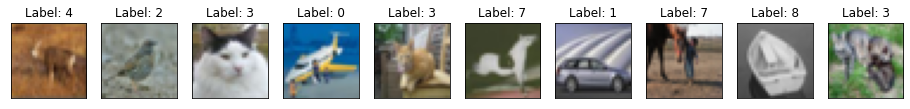

********************            10 Validation Images            ********************


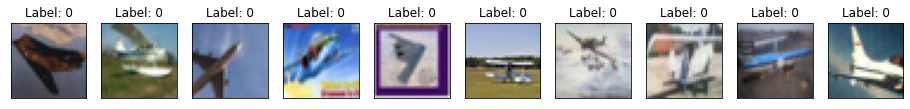

********************            10 Test Images            ********************


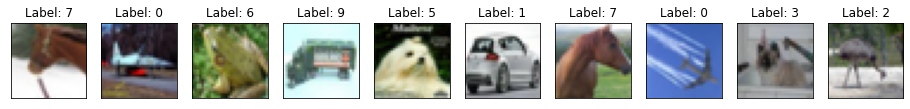

In [100]:
#@view_image(ds)
def view_image(ds, opttext = "", batch = 10):
# this function takes the dataset and automatically displays 10 figures
# the dataset has to be batches to see the images
  ds  = make_batched(ds, batch)

  image, label = next(iter(ds)) # extract 1 batch from the dataset
  image = image.numpy().astype("uint8")  #??  #if theres a better way to do this I'm all ears because it's costly
  label = label.numpy()   
  

  fig = plt.figure(figsize=(16, 16))
  for i in range(10):
    if i == 1:
        print("*"*20, " "*10, opttext, " "*10,  "*"*20)
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    ax.imshow(image[i])
    ax.set_title(f"Label: {label[i]}")
    if i == 9:
      plt.pause(0.05)  # heck yea
      


view_image(train_A, opttext = "10 Training Images from Group A")
view_image(val, opttext = "10 Validation Images")
view_image(x_test, opttext = "10 Test Images")


To integrate `albumentations` into our tensorflow pipeline we can create two functions :  
- Pipeline to apply `augmentation`.
- a function that calls the above function and pass in our data through the pipeline.
We can then wrap our 2nd Function under `tf.numpy_function` .

### Define Albumentations "Transform" Augmentation Functions (transforms = Compose([ ... ])   ) 

In [163]:
#@title def augmentfunction(df_experimentalruns, run): { form-width: "20px" }
IMG_SIZE = 32

def augmentfunction(df_experimentalruns, run):
    
  # Instantiate augments

  cat_probability = 1
  cont_probability = 1
  random.seed(42)

  # Assign Continuous Factors Levels by Run -------------------------

  shift_limit_x_left =  df_experimentalruns.loc[run,"shiftX"]
  shift_limit_x_right = df_experimentalruns.loc[run,"shiftX"]  
  assert shift_limit_x_right >= shift_limit_x_left
  assert shift_limit_x_right <= 1  #more than one is damaging
  print("Shift X: (", shift_limit_x_left, ",", shift_limit_x_right, ") or (",-shift_limit_x_right, ",", -shift_limit_x_left, ")" )

  shift_limit_y_left = df_experimentalruns.loc[run,"shiftY"]
  shift_limit_y_right = df_experimentalruns.loc[run,"shiftY"]  
  assert shift_limit_y_right >= shift_limit_y_left
  assert shift_limit_y_right < 1  #more than one is damaging
  print("Shift Y: (", shift_limit_y_left, ",", shift_limit_y_right, ")or (", -shift_limit_y_right, ",", -shift_limit_y_left, ")")


  gamma_left =  df_experimentalruns.loc[run,"gamma"]     
  gamma_right = df_experimentalruns.loc[run,"gamma"]  
  assert gamma_right >= gamma_left
  print("Gamma: (", gamma_left, ",", gamma_right, ")")

  zoom_out_left = -df_experimentalruns.loc[run,"zoomOut"]  
  zoom_out_right = -df_experimentalruns.loc[run,"zoomOut"] 
  assert zoom_out_right >= zoom_out_left
  print("ZoomOut: (", zoom_out_left, ",", zoom_out_right, ")")


  zoom_in_left = df_experimentalruns.loc[run,"zoomin"]
  zoom_in_right = df_experimentalruns.loc[run,"zoomin"]
  assert zoom_in_right >= zoom_in_left
  assert zoom_in_right < 1.0
  print("ZoomIn: (", zoom_in_left, ",", zoom_in_right, ")")



  noise_left = df_experimentalruns.loc[run,"noise"]             # df_factors["Noise"][df_experimentalruns.loc[run,"Noise"]])
  noise_right = df_experimentalruns.loc[run,"noise"]         #  need to change noise to larger number
  assert noise_right >= noise_left
  print("Noise: (", noise_left, ",", noise_right, ")")


  ## Is blur of 7 too high? :-\ 
  if df_experimentalruns.loc[run,"blur"] == 0:
    blur_probability = 0
    # print("blur is 0")
    blur_left = 0
    blur_right = 0+1
  else:
    # print("blur is not 0")
    blur_probability = 1
    blur_left = df_experimentalruns.loc[run,"blur"]
    blur_right = df_experimentalruns.loc[run,"blur"]
  assert blur_right >= blur_left
  assert blur_right > 0  # must be an integer  #I can't see a dfference using 7 and 9!
  print("blur: (", blur_left, ",", blur_right, ")")


  # Need to add Sharp to the menu of options
  sharp_left = df_experimentalruns.loc[run,"sharpen"]
  sharp_right = df_experimentalruns.loc[run,"sharpen"]
  assert sharp_right >= sharp_left
  print("sharp: (", sharp_left, ",", sharp_right, ")")


  contrast_limit_left = df_experimentalruns.loc[run,"contrast"]
  contrast_limit_right = df_experimentalruns.loc[run,"contrast"]
  assert contrast_limit_right >= contrast_limit_left
  print("Contrast: (", contrast_limit_left, ",", contrast_limit_right, ")")


  brightness_limit_left = df_experimentalruns.loc[run,"brighten"]
  brightness_limit_right = df_experimentalruns.loc[run,"brighten"] 
  assert brightness_limit_right >= brightness_limit_left
  print("Bright: (", brightness_limit_left, ",", brightness_limit_right, ")")

  darkness_limit_left = -df_experimentalruns.loc[run,"darken"] 
  darkness_limit_right = -df_experimentalruns.loc[run,"darken"]
  assert darkness_limit_right >= darkness_limit_left
  print("Darken: (", darkness_limit_left, ",", darkness_limit_right, ")")


  rotate_left  = df_experimentalruns.loc[run,"rotate"]
  rotate_right = df_experimentalruns.loc[run,"rotate"]
  assert rotate_right >= rotate_left
  print("Rotate: (", rotate_left, ",", rotate_right, ") or (",-rotate_right, ",", -rotate_left, ")" )


  crop_value = 32-df_experimentalruns.loc[run,"crop"]


  # Assign Categorical Factors Probabilities to make "on" or "off" -------------------------
  pHorizontalFlip =   df_experimentalruns.loc[run,"flipH"]
  print("pHorizontalFlip: ", pHorizontalFlip)

  pVerticalFlip =     df_experimentalruns.loc[run,"flipV"]
  print("pVerticalFlip: ", pVerticalFlip)

  pEqualize =          df_experimentalruns.loc[run,"equalize"]
  print("pEqualize: ", pEqualize)

  pFancyPCA =          df_experimentalruns.loc[run,"fancyPCA"]
  print("pFancyPCA: ", pFancyPCA)

  pChannelShuffle =   df_experimentalruns.loc[run,"channelShuffle"]
  print("pChannelShuffle: ", pChannelShuffle)

  pElasticTransform =  df_experimentalruns.loc[run,"elasticTransform"]
  print("pElasticTransform: ", pElasticTransform)

  pToGray =            df_experimentalruns.loc[run,"togray"]
  print("pToGray: ", pToGray)

  background_value = 0

  print("*"*100, "\n\n")

  #transforms = A.Compose([
  list_of_transforms = [


      #1. Shift Horizontally Right or Shift Horizontally Left
      A.OneOf([
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=0, 
                                                  shift_limit_x=(shift_limit_x_left,shift_limit_x_right), 
                                                  scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value),    
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=0, 
                                                  shift_limit_x=(-shift_limit_x_right,-shift_limit_x_left), 
                                                  scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value)], 
              p=cont_probability),
      
      
      # 2 Shift VERTICALLY  up or down 
      A.OneOf([
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=(shift_limit_y_left,shift_limit_y_right), shift_limit_x=0, scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value),   
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=(-shift_limit_y_right, -shift_limit_y_left), shift_limit_x=0, scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value)], 
              p =cont_probability),
      
      #3 NOISE ---------------------------------
      A.transforms.GaussNoise(var_limit=(noise_left,noise_right), p=cont_probability),  

      #4 BLUR
      A.transforms.GaussianBlur(blur_limit=(blur_left,blur_right), sigma_limit=(0.5,0.05), p=blur_probability),  #Blur
      
      #5 Sharpen 
      A.transforms.Sharpen(alpha=(sharp_left,sharp_right), lightness=(0.0, 0.0), p=cont_probability),  #AntiBlur keep lightness constant at 0?
        
      #6 Contrast
      A.transforms.RandomBrightnessContrast(brightness_limit=(0,0), contrast_limit=(contrast_limit_left,contrast_limit_right), p=cont_probability),       

      #7 Brightness
      A.transforms.RandomBrightnessContrast(brightness_limit=(brightness_limit_left,brightness_limit_right), contrast_limit=(0,0), p=cont_probability),      
      
      #8 Darkness
      A.transforms.RandomBrightnessContrast(brightness_limit=(darkness_limit_left,darkness_limit_right), contrast_limit=(0,0), p=cont_probability),  #darkness

      #9 GAMMA
      # A.transforms.RandomGamma(gamma_limit=(gamma_left,gamma_right), p=cont_probability),  
      

      #10 Zoom Out
      A.geometric.ShiftScaleRotate(rotate_limit=0,  shift_limit_y=0, shift_limit_x=0, scale_limit=(zoom_out_left,zoom_out_right), border_mode=cv2.BORDER_CONSTANT, value=background_value, p=cont_probability),    #Zoom Out safe: scale_limit=(-0.15,-0.1)

      #11  Rotate CW or CCW
      A.OneOf([
                    A.geometric.SafeRotate(limit=(rotate_left,rotate_right), border_mode=cv2.BORDER_CONSTANT, value=background_value),
                    A.geometric.SafeRotate(limit=(-rotate_right,-rotate_left), border_mode=cv2.BORDER_CONSTANT, value=background_value)], p=1),
      
      #12  Crop then Pad
      A.crops.transforms.CenterCrop(height=crop_value, width=crop_value,  p=cont_probability),       # Crop 24,24 is the extreme
      A.transforms.PadIfNeeded(min_height=32, min_width=32,  border_mode=cv2.BORDER_CONSTANT, value=background_value, p=1),

      # 13 ZoomIn
      A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=0, shift_limit_x=0,
                                    scale_limit=(zoom_in_left,zoom_in_right), border_mode=cv2.BORDER_CONSTANT, value=background_value, p=cont_probability),  

      # 14 FlipH
      A.HorizontalFlip(p=pHorizontalFlip),
      
      # 15 FlipVert
      A.VerticalFlip(p=pVerticalFlip),
      
      #16 FANCY PCA
      A.transforms.FancyPCA(alpha=0.1, p=pFancyPCA),                    # FancyPCA Amount to perturn eigenvalues not Categorical
      
      #17 Elastic Transform
      A.geometric.ElasticTransform(alpha=0.1, sigma=0.001, alpha_affine=0.001, 
                                    same_dxdy=True, border_mode=cv2.BORDER_CONSTANT, 
                                    value=background_value, p=pElasticTransform),    #Seems more like a blur than a transform?
      
      # #Resize to 32x32 for crop
      # A.geometric.Resize(height=32, width=32, p=1),

      #18 Histogram Equalizer
      A.transforms.Equalize(p=pEqualize),  

      #19 CHANNELSHUFFLE
      A.transforms.ChannelShuffle(p=pChannelShuffle),  #this is prob going to ruin accuracy


      #20 Turn Everything Gray
      A.transforms.ToGray(p=pToGray)

    ] 
    
  return list_of_transforms

global no_transforms 

no_transforms = A.Compose([
         A.transforms.NoOp()
])

### Define another function "Augment_Function" to push images throguh list of "Transforms" to create augmented images

In [164]:
#@title aug_fn

#this function is being referenced a lot

def aug_fn(image, img_size ):
    data = {"image":image}
    
    aug_data = transforms(**data)
    
    aug_img = aug_data["image"]
    # aug_img = tf.cast(aug_img/255.0, tf.float32)
    # aug_img = tf.cast(aug_img/1.0, tf.float32)    #attempt
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    # aug_img = tf.cast(aug_img*255.0, tf.float32)

    return aug_img

def no_aug_fn(image, img_size):
    data = {"image":image}

    aug_data = no_transforms(**data)

    aug_img = aug_data["image"]
    # aug_img = tf.cast(img/255.0, tf.float32)  
    # aug_img = tf.cast(img/1.0, tf.float32)      #new attempt
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    # aug_img = tf.cast(aug_img*255.0, tf.float32)
    return aug_img

#### Define Process_Data function to returns augmented image andlabel

In [165]:
#@title process_data { form-width: "20px" }
def process_data(image, label, img_size,):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)  # was tf.float32
    return aug_img, label


def no_process_data(image, label, img_size,):
    no_aug_img = tf.numpy_function(func=no_aug_fn, inp=[image, img_size], Tout=tf.float32)   # was tf.float32
    return no_aug_img, label
    

#### Restoring dataset shapes. 
The datasets loses its shape after applying a tf.numpy_function, so this is necessary for the sequential model and when inheriting from the model class.

In [166]:
#@title set_shapes
def set_shapes(img, label, img_shape=(IMG_SIZE,IMG_SIZE,3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label

`Note`: 
Some `API's` of `tensorflow.keras.Model` might not work, if you dont map the dataset with the set_shapes function.

## Create New Training Group Data by Merging Un-Augmented with Augmented Data


In [167]:
#@ 

def unbatch_ds(batchedDataset):
  unbatch_ds = (tf.data.Dataset.unbatch(batchedDataset))
  return unbatch_ds


# unbatch_train_A = make_unbatched(train_A)

#as of 11/11/21 a 0521 added transforms to try to make my run_through_runs 
#   function pass the transforms to the augment functions

def augment_data(dataset, process, dataset_text=""):
  dataset_new = dataset.map(partial(process, img_size=IMG_SIZE,))
  dataset_new = dataset_new.map(set_shapes)
  # dataset_new = dataset_new.batch(batchsize)
  # get_min_max(dataset,      text= dataset_text)
  # get_min_max(dataset_new,  text=str("New" + dataset_text))
  return dataset_new



In [168]:
#@title
# #@title View No Augmentation Dataset { form-width: "20%" }
# train_A_noalb = augment_data(dataset = unbatch_train_A, 
#                              process= no_process_data,
#                             #  batchsize=100,
#                              dataset_text = "train_A_noalb")

# #@title View No Augmentation Dataset { form-width: "20%" }
# train_B_noalb = augment_data(dataset = make_unbatched(train_B), 
#                              process= no_process_data,
#                             #  batchsize=100,
#                              dataset_text = "train_A_noalb")
# pretty_display_of_dataset(train_B_noalb)


In [169]:
#@title PrettyViewofData Function { form-width: "30px" }
def pretty_display_of_dataset(ds, dstitle = "Dataset title", opttext = ""):
  view_image(ds, dstitle)  #defaults to batch size 10 
  num = ds.reduce(np.int64(0), lambda x,_ : x + 1).numpy()  # returns 25, but 25*100batches = 2500
  
  if check_if_batched(ds):
    print("Total: ", num, " batches in this dataset: \n\n\n", opttext )

    if num > 5:
      num = 5
      print("Showing first 10 images of the first five batches")
    
    batch1 = ds.take(1)
    
    view_image(batch1, str("Batch1 of "+dstitle)) 
    print("Batch ",1, "Class Count:", count_cifar10_class(batch1), "\n")  

    for i in range(2,num+1):      
      batch2 = ds.skip(i-1).take(1)
     
      name_of_batch = str("Batch" + str(i)+" of "+ dstitle)
      view_image(batch2, name_of_batch )   
      print("Batch ", i, "Class Count:", count_cifar10_class(batch2), "\n")
      # do I need to clear out batch2 here?

  else:
    print("Total: ", num, " images in this dataset", opttext )
    print("Total Class Count:", count_cifar10_class(ds), "\n")

  
  print("**********************************************************************************************")

# pretty_display_of_dataset(train_A, "Train_A")  



#### View_Num_Images Function, default num = 20

In [170]:
#@title
def view_num_images(ds, num = 20):

  ds = make_batched(ds, batchnum = num)

  image, label = next(iter(ds)) # extract 1 batch from the dataset
  image = image.numpy().astype("uint8")  #??  #if theres a better way to do this I'm all ears because it's costly
  label = label.numpy()   
  
  fig = plt.figure(figsize=(10, 10))

  for i in range(num):
      ax = fig.add_subplot(1, num, i+1, xticks=[], yticks=[])
      ax.imshow(image[i])
      ax.set_title(f"Lbl: {label[i]}")
      

In [189]:
#@title show_confusion_matrix_wo_diagonal { form-width: "2px" }
def show_confusion_matrix_wo_diagonal(test_labels, predictions, CLASSES, run=999):
    """Compute confusion matrix without diagonal."""
    confusion = sklearn.metrics.confusion_matrix(test_labels, predictions,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    confusion_matrix_wo_diagonal= np.array(confusion)-np.identity(confusion.shape[0])*np.diag(confusion)

    axis_labels = CLASSES

    ax = sns.heatmap(
        confusion_matrix_wo_diagonal, xticklabels=axis_labels, yticklabels=axis_labels, 
        cmap='Blues', annot=True, square=True, fmt='.0f', cbar = False)

    plt.title(str("Confusion Matrix without Diagonal of Run " + str(run)))
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    print("Summing down the rows, for Predictions of each Class that were wrong: ", confusion_matrix_wo_diagonal.sum(axis=0))

    # for i in range(10):
    print("For example, the model predicted a  label 4 (deer) on a true  ", np.argmax(confusion_matrix_wo_diagonal[:,4])," a total of ", max(confusion_matrix_wo_diagonal[:,4]), "times")

    print("Summing across the columns, for total number of that True Class misidentified: ", confusion_matrix_wo_diagonal.sum(axis=1))
    
    print("For example, the model misclassified true 4's (deer) as label  ", np.argmax(confusion_matrix_wo_diagonal[4,:]), CLASSES[np.argmax(confusion_matrix_wo_diagonal[4,:])], " a total of ", max(confusion_matrix_wo_diagonal[4,:]), "times")





In [172]:
#@title
# The augmented data returns floats between 0 and 1
# The unaugmented data is integers uint8 between 0 and 255 
CLASSES = info.features['label'].names

# This may help me one day with trying to get into the ID of each batch/mislabelled image
# info.features['id']


In [173]:
#@title cache_prefetch_group(train_tf, shuffle=5000, batch =0, SEED = 42) { form-width: "4px" }

def cache_prefetch_group(train_tf, SHUFFLE=5000, batch = 0, SEED = 42):
    # I choose to shuffle the entire deck, which probably adds time, but I want to ensure mixed unaugmented and augmented
    train_tf = train_tf.shuffle(SHUFFLE, reshuffle_each_iteration=False)  # I took out seed=seed to get variety with each reshuffle
    # as of 11/10/21 9 pm I changed reshuffle_each_iteration to False, because I think that will ensure I get at least all of the dataset images in a batch
    # as of 11/11/21 4 Am I changed reshuffle_each_iteration back to True, because train_B imagesdidnt look sufficiently shuffled in a batch

    train_tf = train_tf.cache().prefetch(buffer_size=AUTOTUNE)
    if batch != 0:
      train_tf = train_tf.batch(batch)  # ??moved Batch to inside ModelTraining loop to prevent Double-Batching-Weirdness
    return train_tf 


#### Make Sortedd Test Accuracy Dictionary  Functions

In [174]:
#@title make_accuracy_dictionary(cm_norm)
# define function to print out all the labels amd accuracies on the diagonal of the confusion matrix
def make_accuracy_dictionary(cm_norm):
  dictionary = {}
  for i in range(10):
    dictionary[CLASSES[i]] = cm_norm[i,i]
    
  # sort the values - ty SO https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value/613218#613218
  for w in sorted(dictionary, key=dictionary.get, reverse=True):
    print(w, dictionary[w])
  return dictionary 


# define function to print out all the labels amd accuracies on the off diagonal of the confusion matrix
# to indicate the most common mistakes:

# def make_misclassification_dictionary(cm):
#   dictionary = {}

#   for i in range(10):
#     dictionary_cm_diagonal_labels[CLASSES[i]] = cm_norm[i,i]
    
#   # sort the values - ty SO https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value/613218#613218
#   for w in sorted(dictionary_cm_diagonal_labels, key=dictionary_cm_diagonal_labels.get, reverse=True):
#     print(w, dictionary_cm_diagonal_labels[w])
#   return dictionary_cm_diagonal_labels 

# Run, Model, Test, Capture all 50 Designed Runs

In [175]:
#@title
## This is code found on SO to see whether the dataset is batched or not
#  
# train_A_alb.batch(num_alb).__class__.__name__

# new_train_A = new_train_A.batch(10)

# new_train_A._input_dataset.__class__.__name__

# new_train_A = (tf.data.Dataset.unbatch(new_train_A))

In [176]:
def count_images(ds, opttext = ""):
  # The number of images present in the new train_A_alb set is equal to the original set
  num_images = ds.reduce(np.int64(0), lambda x,_ : x + 1).numpy()  # returns 10 bc no batches
  print(" There are ** ", num_images, "** total images in " ,  opttext)
  return num_images

Original Working Code for Train_A before it became a function:

In [177]:
#@title
 
# # ---------------------------------------------------------------------------
# # Create Training-Group-Specific Dictionary to collect important metrics at the end of all runs 
# # ----------------------------------------------------------------------------
# Group_A_Runs = {}   #dictionary

# # Group_A_Runs[run] = {'TestAccuracy': 0}


# # ---------------------------------------------------------------------------
# # When in troubleshooting or refining/code mode, I only run 5 experimental runs but
# # when running the full design matrix, ensure ENDRUNS = 51  (50 + baseline run)
# # the for loop will go through each run like this: df_experimentalruns.loc[run, "WhateverFactors"]:
# # ----------------------------------------------------------------------------

# ENDRUNS = 51
# # assert ENDRUNS == 50

# for run in range(0,ENDRUNS): 

#   # run = run + 1  # commented out after I added a Do-Nothing Run, I now have a real index 0 in the test-run-matrix  
#   print("\n", (str(run) + " ")*50)
#   print("\n   Begin Run: ", run)
#   print("\n", (str(run) + " ")*50)
  

#   #Use my vanilla CNN model function to build a  model with a certain dropout level
#   model = makemodel(DROPOUT=df_experimentalruns.loc[run,'dropout'])

# # ------------------------------------
# # Create Run-Specific Transformations 
# # ------------------------------------

#   # build  Albumentations list of transformations by passing each run's required parameters 
#   list_of_transforms = augmentfunction( df_experimentalruns, run )

#   # pass the list of transforms to Albumentations Compose function
#   transforms = A.Compose(transforms = list_of_transforms)
  
# # ------------------------------------
# # Create Augmented Dataset train_A_alb 
# # ------------------------------------
  
#   # Augment the unbatched Training_Group_A through the Process_Data Function to create train_A_alb (albu = albumentations/augmentations)
#   train_A_alb = augment_data(dataset = unbatch_train_A, process= process_data, dataset_text = "Augmented Dataset")
  
# # ------------------------------------
# # Print the number of total images in each unbatched dataset train_A_alb, and train_A_noalb 
# # -----------------------------------

#   # The number of images present in the new train_A_alb set is equal to the original set
#   # num_alb = count_images(train_A_alb, opttext="Augmented-train-a, before batching")
#   # print("Train_A_Alb has class count:", count_cifar10_class(train_A_alb))
#   # pretty_display_of_dataset(train_A_noalb, "Train Set A - NO Augmentations", opttext = "before batching")


#   # The number of images present in the new train_A_alb set is equal to the original set
#   # count_images(train_A_noalb, "Not-Augmented Train_A, before batching")
#   # print("Train_A_No_Augmentations has class count:", count_cifar10_class(train_A_noalb))
#   # pretty_display_of_dataset(train_A_alb, "Train Set A - Augmentations", opttext = "before batching")


#   # ------------------------------------
#   # Merge/Concatenate Augmented and Non-Augmented into dataset: NEW_TRAIN_A,  then return the total count of images 
#   # ------------------------------------
#   new_train_A = train_A_noalb.concatenate(train_A_alb)
#   # at 9pm I switched the order of these because I think I'm not seeing no_aug until the very last batches? I need to shuffle the batches....
#   #pretty_display_of_dataset(new_train_A, "New Training Set A - Merged with the Augmented, and Non-Augmented", opttext = "before batching")

# # ------------------------------------
# # Batch Consolidated Dataset  
# # ------------------------------------
#   new_train_A_batch = 250 
#   tot_new_train_A = 5000 # should be 250*10*2 = 5000

#   new_train_A = cache_prefetch_group(new_train_A,  SHUFFLE=tot_new_train_A, batch=new_train_A_batch, SEED = seed)

# # ------------------------------------
# # Send Consolidated Dataset through Model & View Model Training Statistics Output 
# # ------------------------------------
#   # take the created model from passing dropout, and pass the training data through it
#   modeltrained = trainmodel(MODEL = model, TRAININGDATA= new_train_A)

# # ------------------------------------
# # See pictures that were sent through model, up to five batches
# # ------------------------------------
#   pretty_display_of_dataset(ds= new_train_A, dstitle="New Training Set A", opttext= "after Shuffling and Batching") 


# # ------------------------------------
# # Test Statistics for Model 
# # ------------------------------------
#   # Retrieve the TEst Loss and Accuracy after training is complete
#   loss, acc = modeltrained.evaluate(x_test, verbose=0) 
#   print("TestLoss: ", loss, " TestAcc:", acc)



# # ------------------------------------
# # Get Predictions from Test Set to use in Confusion Matrix
# # ------------------------------------

#   #Get the predictions of Y_hat from passing X_Test into the model
#   y_pred = modeltrained.predict(x_test)

#   # The Y_Hats are y_pred of continuous probabilities into a 1-coded label vectors
#   y_pred_1hot = np.argmax(y_pred, axis=1)
#   cm = confusion_matrix(y_true = y_test, y_pred = y_pred_1hot,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ) 
#   cm_norm = confusion_matrix(y_true = y_test, y_pred = y_pred_1hot,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], normalize ='true' ) 
#   # disp = ConfusionMatrixDisplay(cm, display_labels=['airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']).plot()
#   make_accuracy_dictionary(cm_norm)

#   # confusion_matrix(y_true = y_test, y_pred = y_pred_1hot )
#   # show_confusion_matrix(y_test, y_pred_1hot, CLASSES = CLASSES)

# # ------------------------------------
# # Save every 10 runs and final file
# # ------------------------------------
#   Group_A_Runs[run] = {'TestAccuracy': acc, 'TestLoss': loss, 'CM': cm, 'CM_norm': cm_norm}
  
#   if run != 0:
#     if run == 50:      
# # ------------------------------------
# # Save  final file
# # ------------------------------------  
#       with open('runs_groupA_final.pkl', 'wb') as fid:
#           pickle.dump(Group_A_Runs, fid)
#           files.download('runs_groupA_final.pkl')
          
#           timetoprint = datetime.datetime.now().strftime("%a, %d %B %Y %H:%M:%S")
#           print("Final Download attempted : ", timetoprint, " (subtract 3-hours from Hour), and file is called runs_groupA_final.pkl ")
# # ------------------------------------
# # Save  intermittent files
# # ------------------------------------  

#     if run%12 == 0:  #When i =12,24,36, save/download file
#       with open('runs_groupA.pkl', 'wb') as fid:
#           pickle.dump(Group_A_Runs, fid)
#           files.download('runs_groupA.pkl')
          
#           timetoprint = datetime.datetime.now().strftime("%a, %d %B %Y %H:%M:%S")
#           print("Download attempted : ", timetoprint, " (subtract 3-hours from Hour), and file is called runs_groupA.pkl ")

 

### Defining all the no_augmentation groups before model-building-and-testing

In [178]:

# I am having trouble defining no_augmentation datasets inside the for-loop so i decided to define them outside the for-loop
# ------------------------------------
# Create Non-Augmented Dataset train_A_noalb 
# ------------------------------------
# until i figure out a better way , this is my way of ensuring that the unaugmented dataset is compatible datatype with that augmented one
def make_noalb(ds, dstitle):
  train_X_noalb = augment_data(dataset = make_unbatched(ds), process= no_process_data, dataset_text = str("TrainingGroup" + dstitle+ "NotAugmented"),)
  return train_X_noalb

# train_B_noalb = augment_data(dataset = make_unbatched(train_B), process= no_process_data, dataset_text = "Train_BNotAugmented",  passtransforms=no_transforms)
# print("train_B_noalb created")
# pretty_display_of_dataset(train_B_noalb, "noAugmentations") 



train_A_noalb = make_noalb(train_A, "A")
train_B_noalb = make_noalb(train_B, "B")

train_C_noalb = make_noalb(train_C, "C")
train_D_noalb = make_noalb(train_D, "D")

train_E_noalb = make_noalb(train_E, "E")
train_F_noalb = make_noalb(train_F, "F")

train_G_noalb = make_noalb(train_G, "G")
train_H_noalb = make_noalb(train_H, "H")

train_I_noalb = make_noalb(train_I, "I")
train_J_noalb = make_noalb(train_J, "J")

In [195]:
def run_through_runs(ds, ds_noalb, dstitle = "X", showpictures=True):
  filename = "runs_Group" + dstitle
  print("filename will be: ", filename, ".pkl")
  originalfilename = filename
  # ---------------------------------------------------------------------------
  # Create Training-Group-Specific Dictionary to collect important metrics at the end of all runs 
  # ----------------------------------------------------------------------------
  Group_X_Runs = {}   #dictionary
  # Group_X_Runs[run] = {'TestAccuracy': 0}


  # ---------------------------------------------------------------------------
  # For Loop of Runs
  # when running the full design matrix, ensure ENDRUNS = 51  (50 + baseline run)
  # the for loop will go through each run like this: df_experimentalruns.loc[run, "WhateverFactors"]:
  # ----------------------------------------------------------------------------

  ENDRUNS = 51
  # assert ENDRUNS == 51

  for run in range(0,51,5): 
    filename = originalfilename  #reset so you dont get Downloading "runs_GroupA.pkl.pkl.pkl.pkl.pkl.pkl.pkl.pkl.pkl.pkl.pkl.pkl"


    # run = run + 1  # commented out after I added a Do-Nothing Run, I now have a real index 0 in the test-run-matrix  
    print("\n", (str(run) + " ")*50)
    print("\n   Begin Run: ", run)
    print("\n", (str(run) + " ")*50, "\n")
    

    #Use my vanilla CNN model function to build a  model with a certain dropout level
    model = makemodel(DROPOUT=df_experimentalruns.loc[run,'dropout'])

    # ------------------------------------
    # Create Run-Specific Transformations 
    # ------------------------------------

    # build  Albumentations list of transformations by passing each run's required parameters 
    list_of_transforms = augmentfunction( df_experimentalruns, run )

    # pass the list of transforms to Albumentations Compose function
    global transforms 
    transforms = A.Compose(list_of_transforms)

    
    # ------------------------------------
    # Create Augmented Dataset train_A_alb 
    # ------------------------------------
    
    # Augment the unbatched Training_Group_A through the Process_Data Function to create train_A_alb (albu = albumentations/augmentations)
    train_X_alb = augment_data(dataset = ds, process= process_data, dataset_text = "Augmented Dataset", )
    # print("train_X_alb created")
    # pretty_display_of_dataset(train_X_alb, "Augmentations")

    # # ------------------------------------
    # # Create Non-Augmented Dataset train_A_noalb 
    # # ------------------------------------
    # # until i figure out a better way , this is my way of ensuring that the unaugmented dataset is compatible datatype with that augmented one

    # train_X_noalb = augment_data(dataset = ds, 
    #                          process= no_process_data,
    #                         #  batchsize=100,
    #                          dataset_text = str(dstitle+"NotAugmented"), passtransforms=no_transforms)
    # print("train_X_noalb created")
    # pretty_display_of_dataset(train_X_noalb, "noAugmentations") 


    # ------------------------------------
    # Print the number of total images in each unbatched dataset train_A_alb, and train_A_noalb 
    # -----------------------------------
    # removed because counting the items in a dataset is insanely time-expensive, unfortunately



    # ------------------------------------
    # Merge/Concatenate Augmented and Non-Augmented into dataset: NEW_TRAIN_A,  then return the total count of images 
    # ------------------------------------

    new_train_X = ds_noalb.concatenate(train_X_alb)
    # print("new_train_X created")
    # print(new_train_X)
    # pretty_display_of_dataset(new_train_X, "newTrainX") 

    # at 9pm I switched the order of these because I think I'm not seeing no_aug until the very last batches? I need to shuffle the batches....
    #pretty_display_of_dataset(new_train_A, "New Training Set A - Merged with the Augmented, and Non-Augmented", opttext = "before batching")

    # ------------------------------------
    # Batch Consolidated Dataset  
    # ------------------------------------
    new_train_X_batch = 250 
    tot_new_train_X = 5000 # should be 250*10*2 = 5000

    new_train_X= cache_prefetch_group(new_train_X,  SHUFFLE=tot_new_train_X, batch=new_train_X_batch, SEED = seed)
    # print("new_train_X batched")
    # # ------------------------------------
    # # Send Consolidated Dataset through Model & View Model Training Statistics Output 
    # # ------------------------------------
    # # take the created model from passing dropout, and pass the training data through it
    # print("Training Model... ")
    # modeltrained = trainmodel(MODEL = model, TRAININGDATA= new_train_X)

    # # ------------------------------------
    # # See pictures that were sent through model, up to five batches
    # # ------------------------------------
    # if showpictures == True:
    #   pretty_display_of_dataset(new_train_X, dstitle, ) 


    # # ------------------------------------
    # # Test Statistics for Model 
    # # ------------------------------------
    # # Retrieve the TEst Loss and Accuracy after training is complete
    # loss, acc = modeltrained.evaluate(x_test, verbose=0) 
    # print("TestLoss: ", loss, " TestAcc:", acc)



    # # ------------------------------------
    # # Get Predictions from Test Set to use in Confusion Matrix
    # # ------------------------------------

    # #Get the predictions of Y_hat from passing X_Test into the model
    # y_pred = modeltrained.predict(x_test)

    # # The Y_Hats are y_pred of continuous probabilities into a 1-coded label vectors
    # y_pred_1hot = np.argmax(y_pred, axis=1)
    # cm = confusion_matrix(y_true = y_test, y_pred = y_pred_1hot,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ) 
    # cm_norm = confusion_matrix(y_true = y_test, y_pred = y_pred_1hot,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], normalize ='true' ) 
    # # disp = ConfusionMatrixDisplay(cm, display_labels=['airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']).plot()
    # make_accuracy_dictionary(cm_norm)

    # # confusion_matrix(y_true = y_test, y_pred = y_pred_1hot )
    # #def show_confusion_matrix_wo_diagonal(test_labels, predictions, CLASSES):
    # show_confusion_matrix_wo_diagonal(y_test, y_pred_1hot, CLASSES = CLASSES, run=run)

    # # ------------------------------------
    # # Save every 10 runs and final file
    # # ------------------------------------
    # Group_X_Runs[run] = {'TestAccuracy': acc, 'TestLoss': loss, 'CM': cm, 'CM_norm': cm_norm}
    
    


    if run != 0:
      if run == 50:     
        filename = originalfilename + "_final.pkl" 
        # ------------------------------------
        # Save  final file
        # ------------------------------------  
        with open(filename, 'wb') as fid:
          pickle.dump(Group_X_Runs, fid)
          files.download(filename)
          
          timetoprint = datetime.datetime.now().strftime("%a, %d %B %Y %H:%M:%S")
          print("Final Download attempted : ", timetoprint, " (subtract 4-hours from Hour), and file is called ", filename)

      # ------------------------------------
      # Save  intermittent files
      # ------------------------------------  
     
      
      if run%12 == 0:  #When i =12,24,36, save/download file

       filename = str(originalfilename + ".pkl")
       print("As of, run ", run, " the current filename is: ", filename)
       with open(filename, 'wb') as fid:
         pickle.dump(Group_X_Runs, fid)
         files.download(filename)
         
         timetoprint = datetime.datetime.now().strftime("%a, %d %B %Y %H:%M:%S")
         print("Download attempted : ", timetoprint, " (subtract 3-hours from Hour), and file is called",  filename)
         


     

  

filename will be:  runs_GroupB .pkl
Warning Run Starts at 12

 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 

   Begin Run:  12

 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12  

Dropout is:  0.4
Shift X: ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 100 , 100 )
ZoomOut: ( -0.08 , -0.08 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 24 , 24 )
blur: ( 7 , 7 )
sharp: ( 0.1 , 0.1 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 14 , 14 ) or ( -14 , -14 )
pHorizontalFlip:  1
pVerticalFlip:  1
pEqualize:  1
pFancyPCA:  0
pChannelShuffle:  0
pElasticTransform:  1
pToGray:  0
**************************************************************************************************** 


train_X_alb created
Training Model... 
Early-

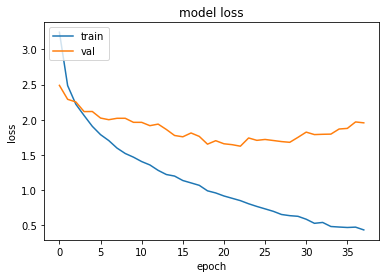

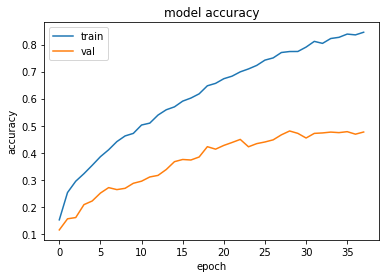

TestLoss:  1.584233045578003  TestAcc: 0.45350000262260437
frog 0.796
automobile 0.583
deer 0.525
ship 0.47
airplane 0.466
truck 0.417
horse 0.398
dog 0.392
cat 0.311
bird 0.177


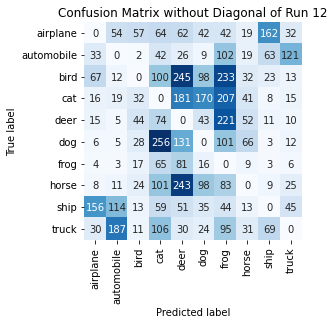

Summing down the rows, for Predicted Class total:  [ 335.  410.  228.  867. 1050.  535. 1128.  282.  351.  279.]
Summing across the columns, for True Class total:  [534. 417. 823. 689. 475. 608. 204. 602. 530. 583.]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download attempted :  Thu, 11 November 2021 14:59:07  (subtract 3-hours from Hour), and file is called runs_GroupB.pkl

 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 

   Begin Run:  13

 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13  

Dropout is:  0.6
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.08 , -0.08 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 0 , 0 )
blur: ( 0 , 1 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.2 , -0.2 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  0
pVerticalFlip:  0
pEqualize:  0
pFancyPCA:  1
pChannelShuffle:  1
pElasticTransform:  0
pToGray:  1
**************************************************************************************************** 

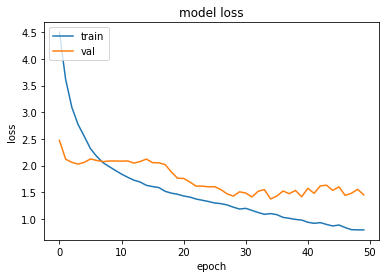

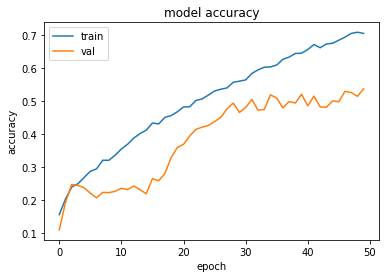

TestLoss:  1.3510687351226807  TestAcc: 0.526199996471405
frog 0.83
automobile 0.647
ship 0.615
truck 0.576
airplane 0.545
horse 0.533
deer 0.515
dog 0.475
bird 0.305
cat 0.221


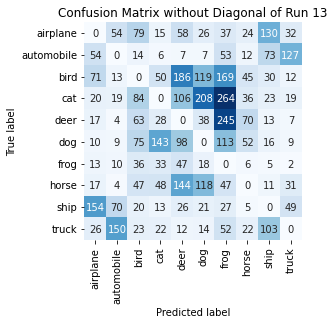

Summing down the rows, for Predicted Class total:  [ 382.  333.  441.  358.  684.  569. 1007.  272.  404.  288.]
Summing across the columns, for True Class total:  [455. 353. 695. 779. 485. 525. 170. 467. 385. 424.]

 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 

   Begin Run:  14

 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14  

Dropout is:  0.4
Shift X: ( 0.0625 , 0.0625 ) or ( -0.0625 , -0.0625 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 100 , 100 )
ZoomOut: ( -0.0 , -0.0 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 0 , 0 )
blur: ( 0 , 1 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  0
pVerticalFlip:  0
pEqualize:  0
pFancyPCA:  0
pChannelShuffle:  0
pElasticTransform:  0
pToGray:  0
**

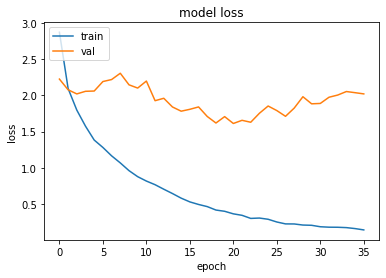

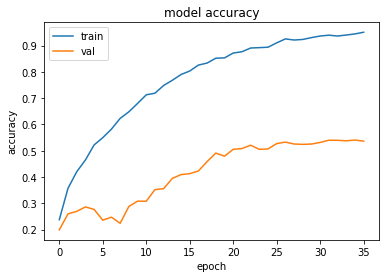

TestLoss:  1.5632413625717163  TestAcc: 0.5091000199317932
ship 0.789
deer 0.725
frog 0.648
truck 0.627
horse 0.515
airplane 0.455
automobile 0.452
dog 0.43
cat 0.241
bird 0.209


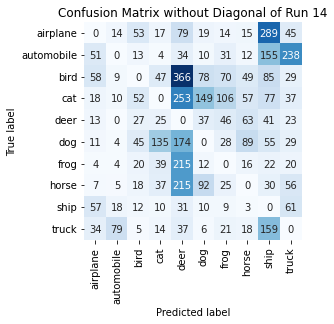

Summing down the rows, for Predicted Class total:  [ 253.  143.  245.  328. 1404.  413.  350.  322.  913.  538.]
Summing across the columns, for True Class total:  [545. 548. 791. 759. 275. 570. 352. 485. 211. 373.]

 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 

   Begin Run:  15

 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15  

Dropout is:  0.6
Shift X: ( 0.0625 , 0.0625 ) or ( -0.0625 , -0.0625 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 24 , 24 )
blur: ( 7 , 7 )
sharp: ( 0.1 , 0.1 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.2 , -0.2 )
Rotate: ( 14 , 14 ) or ( -14 , -14 )
pHorizontalFlip:  1
pVerticalFlip:  1
pEqualize:  1
pFancyPCA:  1
pChannelShuffle:  1
pElasticTransfor

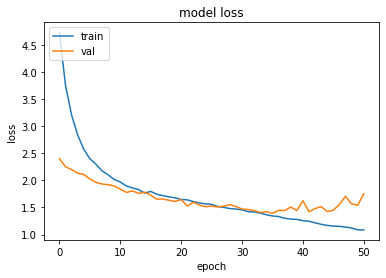

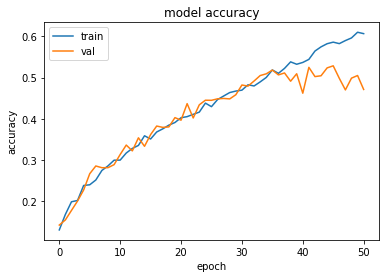

TestLoss:  1.3394243717193604  TestAcc: 0.5188000202178955
frog 0.825
automobile 0.66
truck 0.657
ship 0.598
horse 0.541
dog 0.528
airplane 0.442
deer 0.422
cat 0.271
bird 0.244


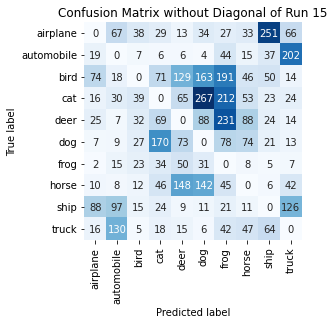

Summing down the rows, for Predicted Class total:  [257. 381. 198. 467. 508. 746. 891. 375. 481. 508.]
Summing across the columns, for True Class total:  [558. 340. 756. 729. 578. 472. 175. 459. 402. 343.]

 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 

   Begin Run:  16

 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16  

Dropout is:  0.4
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 100 , 100 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 24 , 24 )
blur: ( 3 , 3 )
sharp: ( 0.1 , 0.1 )
Contrast: ( 0.0 , 0.0 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  1
pVerticalFlip:  1
pEqualize:  0
pFancyPCA:  0
pChannelShuffle:  0
pElasticTransform:  1
pToGray:  1
************

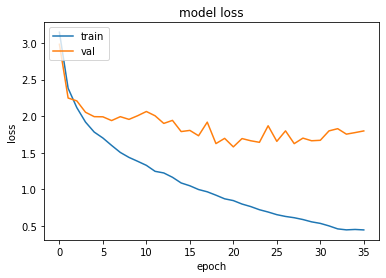

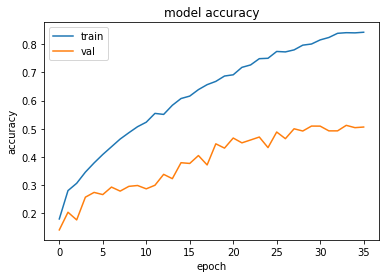

TestLoss:  1.5520013570785522  TestAcc: 0.47290000319480896
frog 0.796
ship 0.656
airplane 0.532
deer 0.499
truck 0.458
dog 0.448
automobile 0.424
cat 0.316
horse 0.309
bird 0.291


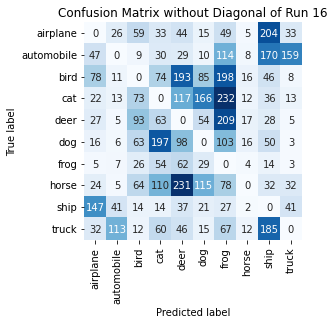

Summing down the rows, for Predicted Class total:  [ 398.  227.  413.  635.  857.  510. 1077.   92.  765.  297.]
Summing across the columns, for True Class total:  [468. 576. 709. 684. 501. 552. 204. 691. 344. 542.]

 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 

   Begin Run:  17

 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17  

Dropout is:  0.6
Shift X: ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 100 , 100 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 24 , 24 )
blur: ( 0 , 1 )
sharp: ( 0.1 , 0.1 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.2 , -0.2 )
Rotate: ( 14 , 14 ) or ( -14 , -14 )
pHorizontalFlip:  0
pVerticalFlip:  1
pEqualize:  0
pFancyPCA:  0
pChannelShuffle:  1
pElasticTransform:  0


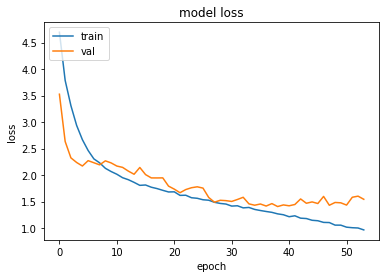

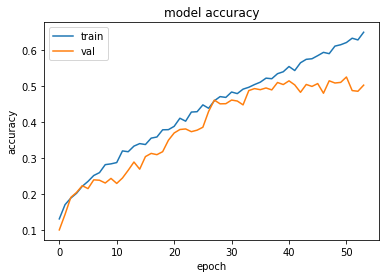

TestLoss:  1.3778377771377563  TestAcc: 0.5194000005722046
frog 0.758
ship 0.709
truck 0.589
airplane 0.558
dog 0.534
horse 0.528
automobile 0.521
deer 0.436
bird 0.363
cat 0.198


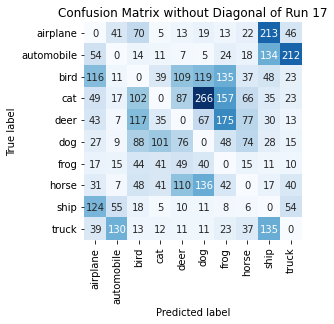

Summing down the rows, for Predicted Class total:  [500. 292. 514. 290. 472. 674. 625. 352. 651. 436.]
Summing across the columns, for True Class total:  [442. 479. 637. 802. 564. 466. 242. 472. 291. 411.]

 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 

   Begin Run:  18

 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18  

Dropout is:  0.4
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 24 , 24 )
blur: ( 7 , 7 )
sharp: ( 0.1 , 0.1 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.1 , 0.1 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  0
pVerticalFlip:  0
pEqualize:  1
pFancyPCA:  1
pChannelShuffle:  1
pElasticTransform:  0
pToGray:  0
********************

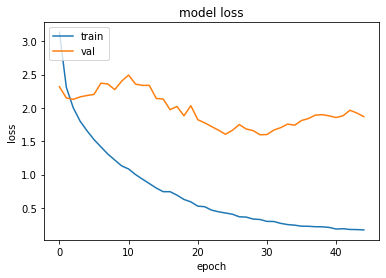

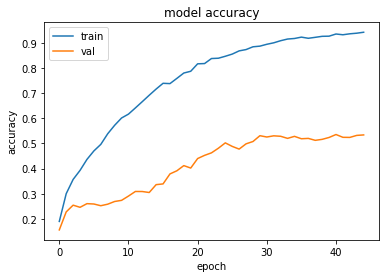

TestLoss:  1.57991361618042  TestAcc: 0.5322999954223633
truck 0.701
frog 0.687
ship 0.654
horse 0.61
deer 0.591
airplane 0.572
automobile 0.523
dog 0.374
bird 0.36
cat 0.251


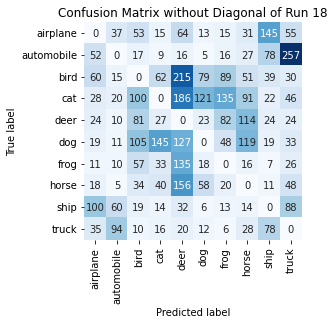

Summing down the rows, for Predicted Class total:  [347. 262. 476. 361. 951. 335. 424. 491. 423. 607.]
Summing across the columns, for True Class total:  [428. 477. 640. 749. 409. 626. 313. 390. 346. 299.]

 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 

   Begin Run:  19

 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19  

Dropout is:  0.6
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 0 , 0 )
blur: ( 0 , 1 )
sharp: ( 0.1 , 0.1 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 14 , 14 ) or ( -14 , -14 )
pHorizontalFlip:  0
pVerticalFlip:  0
pEqualize:  0
pFancyPCA:  0
pChannelShuffle:  0
pElasticTransform:  0
pToGray:  1
******

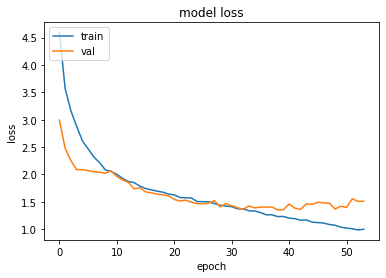

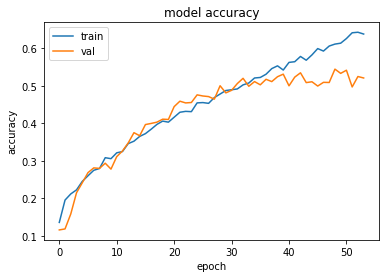

TestLoss:  1.326088786125183  TestAcc: 0.525600016117096
frog 0.728
ship 0.656
truck 0.647
horse 0.635
automobile 0.628
deer 0.524
airplane 0.439
dog 0.372
cat 0.318
bird 0.309


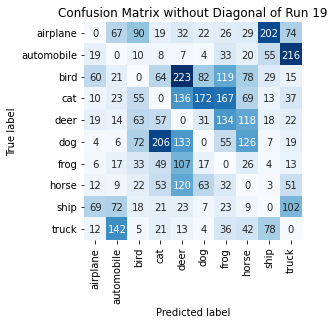

Summing down the rows, for Predicted Class total:  [211. 371. 368. 498. 794. 402. 625. 517. 409. 549.]
Summing across the columns, for True Class total:  [561. 372. 691. 682. 476. 628. 272. 365. 344. 353.]

 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 

   Begin Run:  20

 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20  

Dropout is:  0.6
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 100 , 100 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 0 , 0 )
blur: ( 0 , 1 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  1
pVerticalFlip:  1
pEqualize:  0
pFancyPCA:  1
pChannelShuffle:  1
pElasticTransform:  0
pToGray:  0
********************

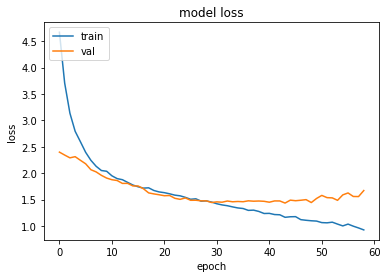

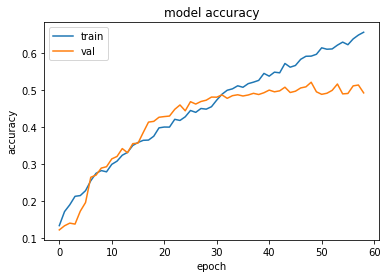

TestLoss:  1.3893402814865112  TestAcc: 0.5127999782562256
horse 0.645
ship 0.638
truck 0.628
automobile 0.623
frog 0.528
airplane 0.517
deer 0.514
dog 0.387
cat 0.335
bird 0.313


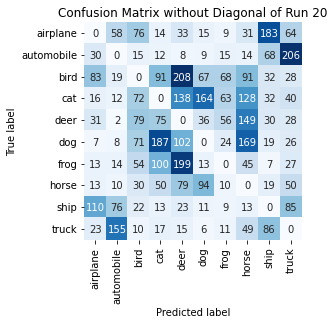

Summing down the rows, for Predicted Class total:  [326. 354. 429. 559. 805. 415. 265. 689. 476. 554.]
Summing across the columns, for True Class total:  [483. 377. 687. 665. 486. 613. 472. 355. 362. 372.]

 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 

   Begin Run:  21

 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21  

Dropout is:  0.6
Shift X: ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 100 , 100 )
ZoomOut: ( -0.0 , -0.0 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 0 , 0 )
blur: ( 0 , 1 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright: ( 0.1 , 0.1 )
Darken: ( -0.2 , -0.2 )
Rotate: ( 14 , 14 ) or ( -14 , -14 )
pHorizontalFlip:  1
pVerticalFlip:  1
pEqualize:  0
pFancyPCA:  0
pChannelShuffle:  0
pElasticTransform:  1
pToGray:  1


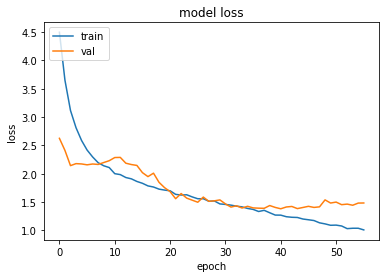

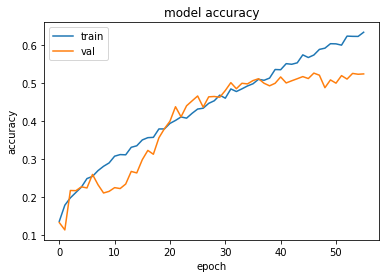

TestLoss:  1.3539592027664185  TestAcc: 0.5282999873161316
frog 0.782
automobile 0.658
airplane 0.647
truck 0.629
horse 0.579
ship 0.529
deer 0.503
dog 0.458
bird 0.291
cat 0.207


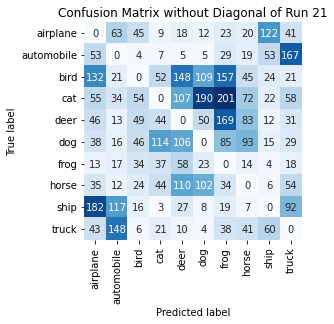

Summing down the rows, for Predicted Class total:  [597. 441. 278. 331. 589. 503. 755. 394. 318. 511.]
Summing across the columns, for True Class total:  [353. 342. 709. 793. 497. 542. 218. 421. 471. 371.]

 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 

   Begin Run:  22

 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22  

Dropout is:  0.4
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.0 , -0.0 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 0 , 0 )
blur: ( 7 , 7 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  1
pVerticalFlip:  0
pEqualize:  1
pFancyPCA:  1
pChannelShuffle:  0
pElasticTransform:  1
pToGray:  1
**********************

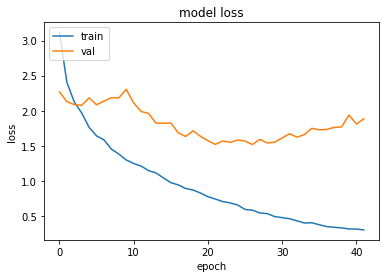

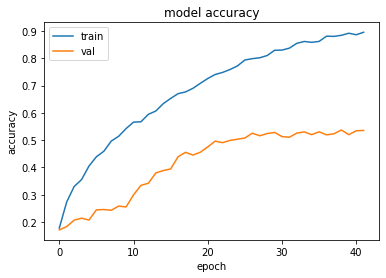

TestLoss:  1.474886178970337  TestAcc: 0.5277000069618225
frog 0.761
ship 0.664
automobile 0.578
truck 0.56
deer 0.545
airplane 0.543
dog 0.5
horse 0.49
cat 0.328
bird 0.308


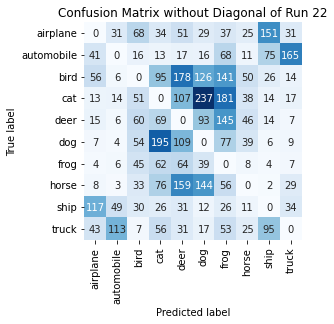

Summing down the rows, for Predicted Class total:  [304. 232. 364. 626. 747. 713. 784. 253. 387. 313.]
Summing across the columns, for True Class total:  [457. 422. 692. 672. 455. 500. 239. 510. 336. 440.]

 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 

   Begin Run:  23

 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23  

Dropout is:  0.6
Shift X: ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.0 , -0.0 )
ZoomIn: ( 0.08 , 0.08 )
Noise: ( 24 , 24 )
blur: ( 0 , 1 )
sharp: ( 0.1 , 0.1 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  1
pVerticalFlip:  0
pEqualize:  0
pFancyPCA:  1
pChannelShuffle:  0
pElasticTransform:  1
pToGray:  1
************

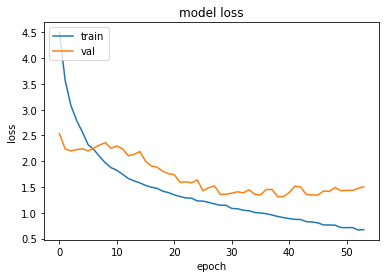

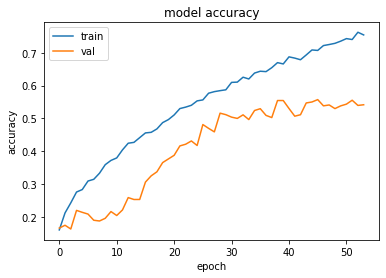

TestLoss:  1.2824779748916626  TestAcc: 0.5577999949455261
frog 0.752
ship 0.733
automobile 0.711
horse 0.629
airplane 0.608
truck 0.595
deer 0.491
dog 0.466
bird 0.313
cat 0.28


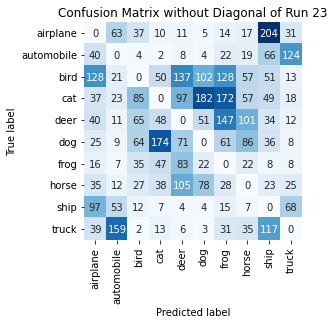

Summing down the rows, for Predicted Class total:  [457. 358. 331. 389. 522. 451. 618. 401. 588. 307.]
Summing across the columns, for True Class total:  [392. 289. 687. 720. 509. 534. 248. 371. 267. 405.]

 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 

   Begin Run:  24

 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24  

Dropout is:  0.4
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 0 , 0 )
blur: ( 7 , 7 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.2 , -0.2 )
Rotate: ( 7 , 7 ) or ( -7 , -7 )
pHorizontalFlip:  0
pVerticalFlip:  1
pEqualize:  0
pFancyPCA:  0
pChannelShuffle:  0
pElasticTransform:  1
pToGray:  1
********************

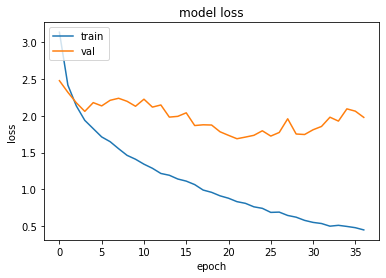

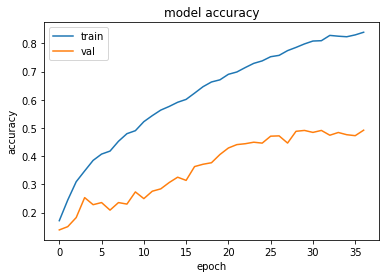

TestLoss:  1.6332887411117554  TestAcc: 0.45660001039505005
ship 0.76
frog 0.738
deer 0.614
automobile 0.518
horse 0.452
cat 0.355
truck 0.354
airplane 0.322
dog 0.245
bird 0.208


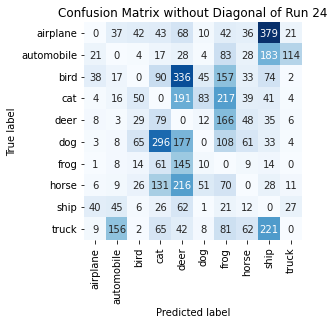

Summing down the rows, for Predicted Class total:  [ 130.  299.  238.  808. 1265.  224.  945.  328. 1008.  189.]
Summing across the columns, for True Class total:  [678. 482. 792. 645. 386. 755. 262. 548. 240. 646.]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download attempted :  Thu, 11 November 2021 15:13:00  (subtract 3-hours from Hour), and file is called  .pkl

 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 

   Begin Run:  25

 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25  

Dropout is:  0.5
Shift X: ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 0 , 0 )
blur: ( 0 , 1 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.2 , -0.2 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  1
pVerticalFlip:  1
pEqualize:  1
pFancyPCA:  1
pChannelShuffle:  0
pElasticTransform:  1
pToGray:  0
**************************************************************************************************** 



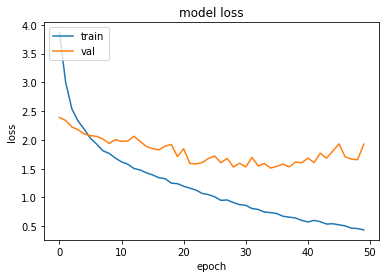

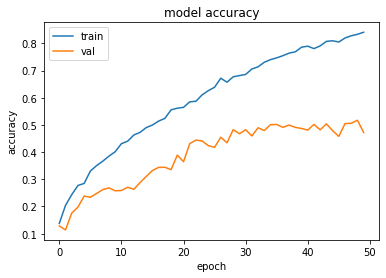

TestLoss:  1.4803792238235474  TestAcc: 0.5037999749183655
dog 0.704
frog 0.686
ship 0.617
automobile 0.564
airplane 0.558
truck 0.537
horse 0.479
deer 0.449
bird 0.237
cat 0.207


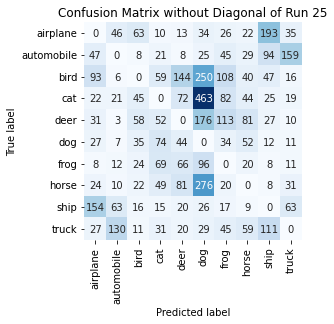

Summing down the rows, for Predicted Class total:  [ 433.  298.  282.  380.  468. 1375.  490.  356.  525.  355.]
Summing across the columns, for True Class total:  [442. 436. 763. 793. 551. 296. 314. 521. 383. 463.]

 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 

   Begin Run:  26

 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26  

Dropout is:  0.4
Shift X: ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.0 , -0.0 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 24 , 24 )
blur: ( 0 , 1 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  0
pVerticalFlip:  1
pEqualize:  1
pFancyPCA:  0
pChannelShuffle:  0
pElasticTransform:  0
pToGra

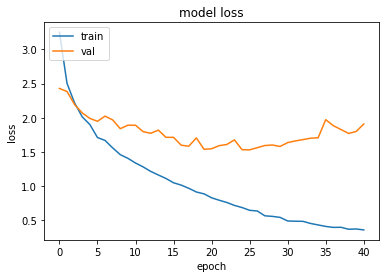

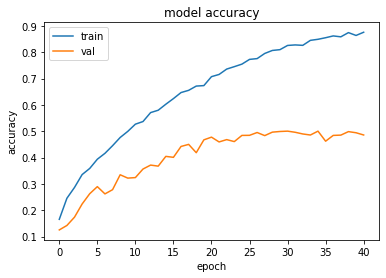

TestLoss:  1.515411376953125  TestAcc: 0.48339998722076416
frog 0.609
airplane 0.604
truck 0.541
horse 0.524
deer 0.519
automobile 0.502
ship 0.498
dog 0.386
cat 0.332
bird 0.319


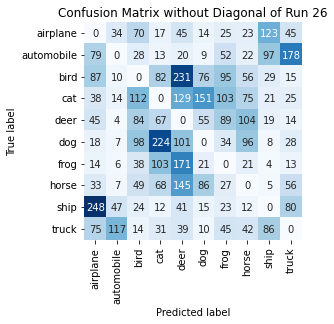

Summing down the rows, for Predicted Class total:  [637. 246. 517. 617. 922. 437. 493. 451. 392. 454.]
Summing across the columns, for True Class total:  [396. 498. 681. 668. 481. 614. 391. 476. 502. 459.]

 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 

   Begin Run:  27

 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27  

Dropout is:  0.6
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 100 , 100 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 24 , 24 )
blur: ( 7 , 7 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.1 , 0.1 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  0
pVerticalFlip:  1
pEqualize:  1
pFancyPCA:  1
pChannelShuffle:  0
pElasticTransform:  0
pToGray:  1
**********

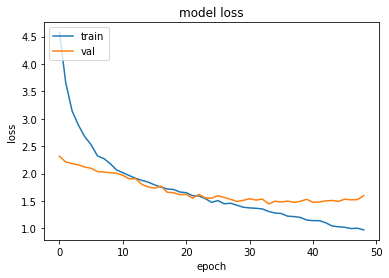

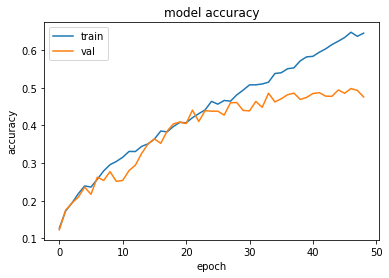

TestLoss:  1.4071487188339233  TestAcc: 0.4846999943256378
frog 0.697
truck 0.624
ship 0.616
horse 0.57
dog 0.533
automobile 0.451
deer 0.428
airplane 0.357
cat 0.297
bird 0.274


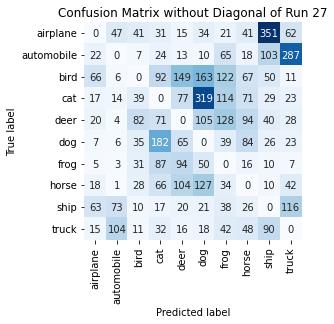

Summing down the rows, for Predicted Class total:  [233. 258. 284. 602. 553. 847. 603. 465. 709. 599.]
Summing across the columns, for True Class total:  [643. 549. 726. 703. 572. 467. 303. 430. 384. 376.]

 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 

   Begin Run:  28

 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28  

Dropout is:  0.6
Shift X: ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 0 , 0 )
blur: ( 7 , 7 )
sharp: ( 0.1 , 0.1 )
Contrast: ( 0.0 , 0.0 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  0
pVerticalFlip:  1
pEqualize:  0
pFancyPCA:  0
pChannelShuffle:  1
pElasticTransform:  1
pToGray:  0
************

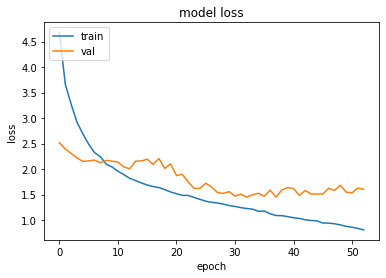

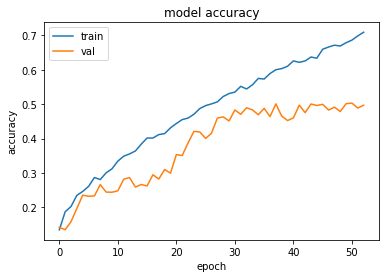

TestLoss:  1.4143671989440918  TestAcc: 0.5031999945640564
frog 0.742
ship 0.604
automobile 0.601
truck 0.557
dog 0.546
airplane 0.51
horse 0.495
deer 0.465
bird 0.261
cat 0.251


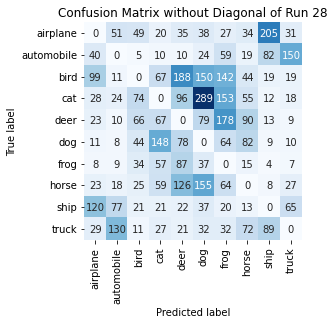

Summing down the rows, for Predicted Class total:  [381. 338. 329. 476. 663. 841. 739. 424. 441. 336.]
Summing across the columns, for True Class total:  [490. 399. 739. 749. 535. 454. 258. 505. 396. 443.]

 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 

   Begin Run:  29

 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29  

Dropout is:  0.4
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.0 , -0.0 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 24 , 24 )
blur: ( 0 , 1 )
sharp: ( 0.1 , 0.1 )
Contrast: ( 0.0 , 0.0 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.2 , -0.2 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  0
pVerticalFlip:  1
pEqualize:  0
pFancyPCA:  1
pChannelShuffle:  1
pElasticTransform:  1
pToGray:  0
************

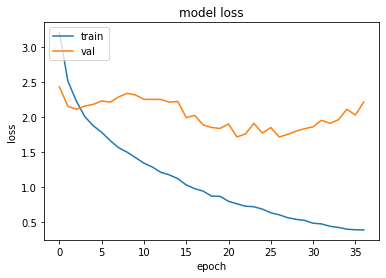

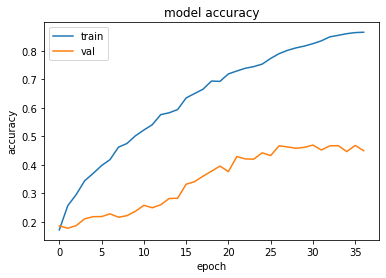

TestLoss:  1.6859534978866577  TestAcc: 0.43779999017715454
frog 0.797
deer 0.617
ship 0.614
truck 0.509
airplane 0.466
automobile 0.33
horse 0.305
dog 0.287
bird 0.241
cat 0.212


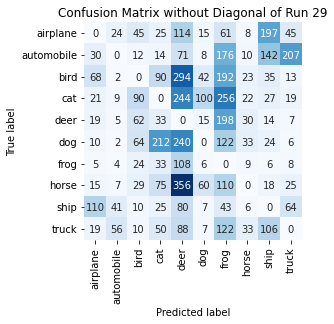

Summing down the rows, for Predicted Class total:  [ 297.  150.  346.  557. 1595.  260. 1280.  174.  569.  394.]
Summing across the columns, for True Class total:  [534. 670. 759. 788. 383. 713. 203. 695. 386. 491.]

 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 

   Begin Run:  30

 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30  

Dropout is:  0.4
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 100 , 100 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 24 , 24 )
blur: ( 0 , 1 )
sharp: ( 0.05 , 0.05 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.2 , -0.2 )
Rotate: ( 14 , 14 ) or ( -14 , -14 )
pHorizontalFlip:  0
pVerticalFlip:  0
pEqualize:  0
pFancyPCA:  1
pChannelShuffle:  0
pElasticTransform:  1
pToGray:  0


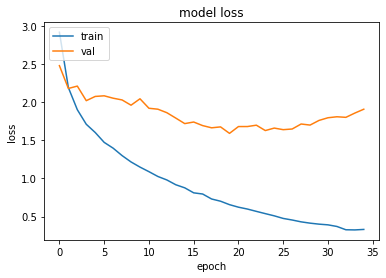

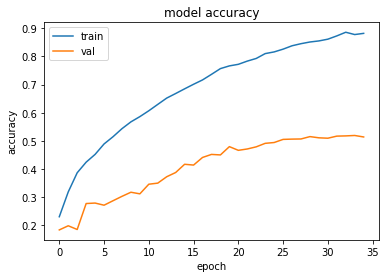

TestLoss:  1.549255132675171  TestAcc: 0.4893999993801117
ship 0.703
airplane 0.617
frog 0.539
deer 0.499
horse 0.495
dog 0.481
automobile 0.441
truck 0.394
bird 0.366
cat 0.359


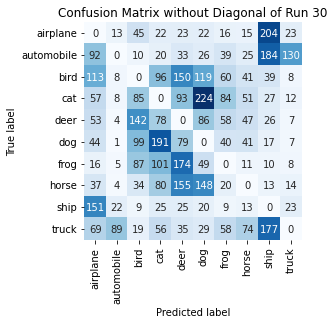

Summing down the rows, for Predicted Class total:  [632. 154. 530. 669. 767. 723. 384. 318. 697. 232.]
Summing across the columns, for True Class total:  [383. 559. 634. 641. 501. 519. 461. 505. 297. 606.]

 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 

   Begin Run:  31

 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31  

Dropout is:  0.6
Shift X: ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 24 , 24 )
blur: ( 7 , 7 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 14 , 14 ) or ( -14 , -14 )
pHorizontalFlip:  0
pVerticalFlip:  0
pEqualize:  0
pFancyPCA:  1
pChannelShuffle:  0
pElasticTransform:  1
pToGray:  

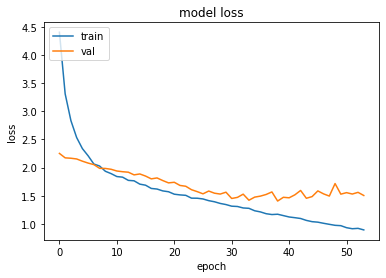

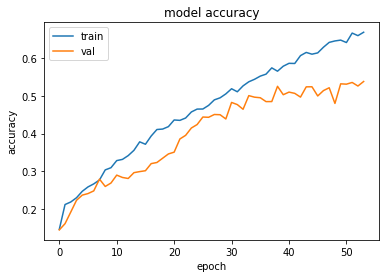

TestLoss:  1.3572121858596802  TestAcc: 0.5325999855995178
frog 0.759
ship 0.676
automobile 0.663
truck 0.616
horse 0.574
dog 0.532
deer 0.471
airplane 0.441
cat 0.378
bird 0.216


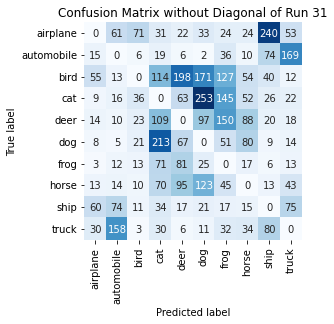

Summing down the rows, for Predicted Class total:  [207. 363. 194. 691. 555. 736. 627. 374. 508. 419.]
Summing across the columns, for True Class total:  [559. 337. 784. 622. 529. 468. 241. 426. 324. 384.]

 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 

   Begin Run:  32

 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32  

Dropout is:  0.4
Shift X: ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 0 , 0 )
blur: ( 0 , 1 )
sharp: ( 0.1 , 0.1 )
Contrast: ( 0.0 , 0.0 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.1 , -0.1 )
Rotate: ( 14 , 14 ) or ( -14 , -14 )
pHorizontalFlip:  0
pVerticalFlip:  1
pEqualize:  1
pFancyPCA:  1
pChannelShuffle:  0
pElasticTransform:  0
pToGray:  1
******

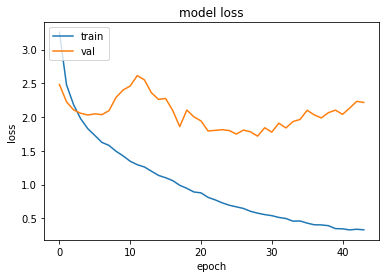

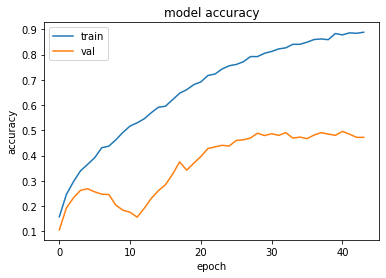

TestLoss:  1.6631072759628296  TestAcc: 0.49939998984336853
frog 0.706
ship 0.657
automobile 0.624
horse 0.621
truck 0.541
deer 0.535
airplane 0.452
dog 0.397
cat 0.257
bird 0.204


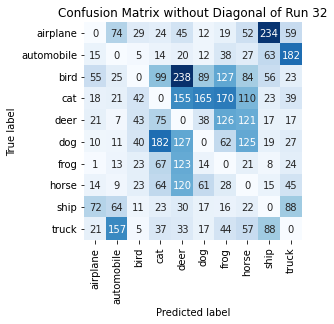

Summing down the rows, for Predicted Class total:  [227. 381. 221. 585. 891. 425. 630. 619. 523. 504.]
Summing across the columns, for True Class total:  [548. 376. 796. 743. 465. 603. 294. 379. 343. 459.]

 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 

   Begin Run:  33

 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33  

Dropout is:  0.6
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.0 , -0.0 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 24 , 24 )
blur: ( 0 , 1 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 14 , 14 ) or ( -14 , -14 )
pHorizontalFlip:  0
pVerticalFlip:  1
pEqualize:  1
pFancyPCA:  0
pChannelShuffle:  1
pElasticTransform:  1
pToGray:  1
****************

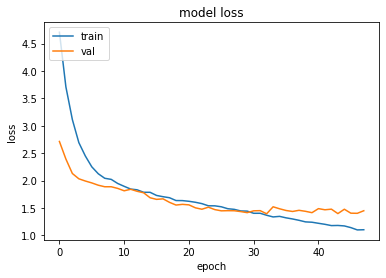

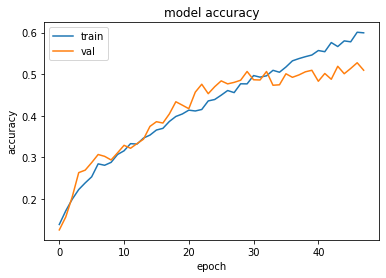

TestLoss:  1.373439908027649  TestAcc: 0.5074999928474426
frog 0.69
ship 0.635
truck 0.607
dog 0.592
horse 0.587
automobile 0.553
airplane 0.515
deer 0.483
cat 0.231
bird 0.182


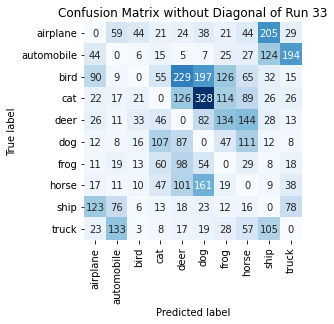

Summing down the rows, for Predicted Class total:  [368. 343. 152. 372. 705. 909. 526. 582. 549. 419.]
Summing across the columns, for True Class total:  [485. 447. 818. 769. 517. 408. 310. 413. 365. 393.]

 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 

   Begin Run:  34

 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34  

Dropout is:  0.6
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 24 , 24 )
blur: ( 0 , 1 )
sharp: ( 0.1 , 0.1 )
Contrast: ( 0.0 , 0.0 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.2 , -0.2 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  1
pVerticalFlip:  0
pEqualize:  1
pFancyPCA:  0
pChannelShuffle:  0
pElasticTransform:  0
pToGray:  0
********************

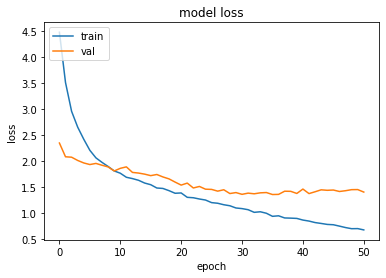

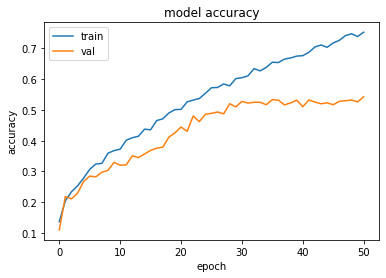

TestLoss:  1.3238189220428467  TestAcc: 0.535099983215332
frog 0.738
ship 0.658
truck 0.601
automobile 0.596
horse 0.559
dog 0.511
airplane 0.489
deer 0.433
cat 0.393
bird 0.373


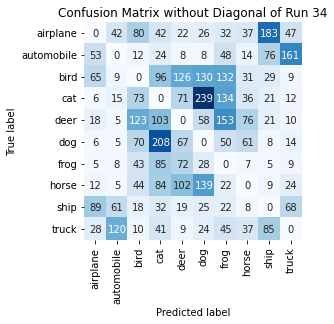

Summing down the rows, for Predicted Class total:  [282. 270. 473. 715. 496. 677. 638. 307. 437. 354.]
Summing across the columns, for True Class total:  [511. 404. 627. 607. 567. 489. 262. 441. 342. 399.]

 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 

   Begin Run:  35

 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35  

Dropout is:  0.4
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 12 , 12 )
blur: ( 0 , 1 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 14 , 14 ) or ( -14 , -14 )
pHorizontalFlip:  1
pVerticalFlip:  0
pEqualize:  1
pFancyPCA:  0
pChannelShuffle:  1
pElasticTransform:  1
pToGray:  0
****

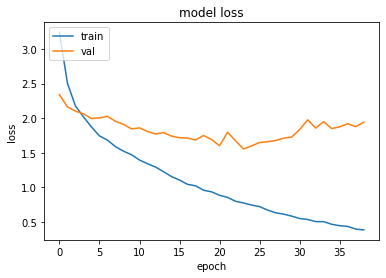

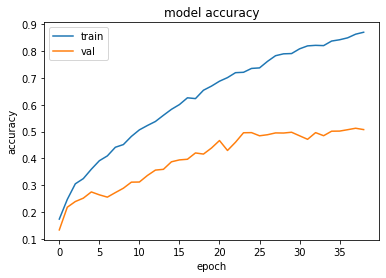

TestLoss:  1.5252292156219482  TestAcc: 0.5040000081062317
frog 0.791
ship 0.678
truck 0.637
automobile 0.581
deer 0.518
horse 0.5
airplane 0.478
dog 0.445
bird 0.259
cat 0.153


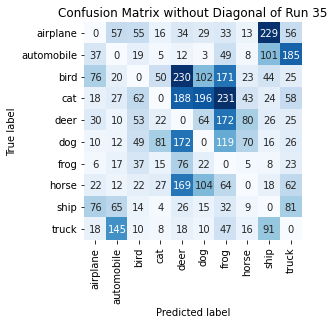

Summing down the rows, for Predicted Class total:  [293. 365. 321. 228. 925. 545. 918. 267. 557. 541.]
Summing across the columns, for True Class total:  [522. 419. 741. 847. 482. 555. 209. 500. 322. 363.]

 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 

   Begin Run:  36

 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36  

Dropout is:  0.4
Shift X: ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.0 , -0.0 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 0 , 0 )
blur: ( 0 , 1 )
sharp: ( 0.1 , 0.1 )
Contrast: ( 0.1 , 0.1 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.2 , -0.2 )
Rotate: ( 14 , 14 ) or ( -14 , -14 )
pHorizontalFlip:  1
pVerticalFlip:  0
pEqualize:  0
pFancyPCA:  0
pChannelShuffle:  1
pElasticTransform:  1
pToGray:  0
**********

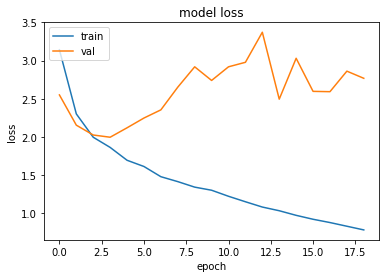

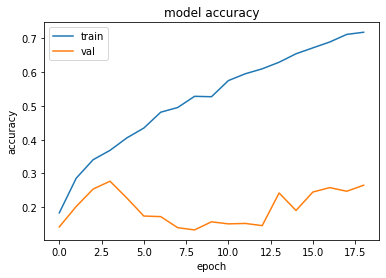

TestLoss:  1.9812449216842651  TestAcc: 0.28769999742507935
frog 0.717
deer 0.439
airplane 0.37
dog 0.359
automobile 0.283
horse 0.228
truck 0.2
ship 0.175
bird 0.098
cat 0.008


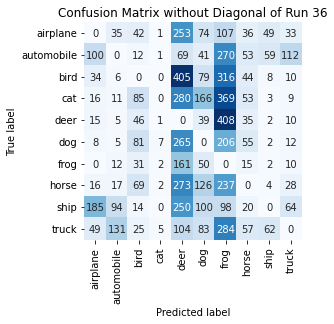

Summing down the rows, for Predicted Class total:  [ 423.  316.  405.   19. 2060.  758. 2295.  368.  191.  288.]
Summing across the columns, for True Class total:  [630. 717. 902. 992. 561. 641. 283. 772. 825. 800.]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download attempted :  Thu, 11 November 2021 15:26:21  (subtract 3-hours from Hour), and file is called  .pkl

 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 

   Begin Run:  37

 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37  

Dropout is:  0.6
Shift X: ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.0 , -0.0 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 0 , 0 )
blur: ( 7 , 7 )
sharp: ( 0.05 , 0.05 )
Contrast: ( 0.0 , 0.0 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  1
pVerticalFlip:  1
pEqualize:  1
pFancyPCA:  0
pChannelShuffle:  1
pElasticTransform:  0
pToGray:  1
**************************************************************************************************** 



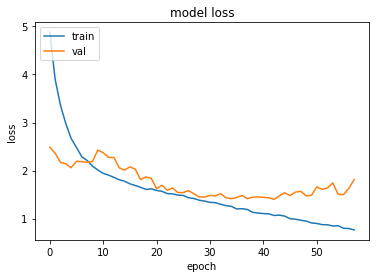

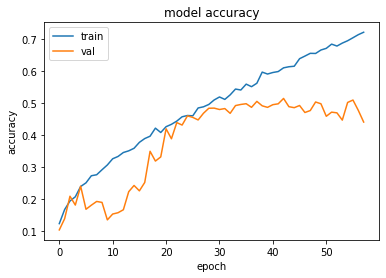

TestLoss:  1.3564504384994507  TestAcc: 0.5184000134468079
frog 0.695
ship 0.684
truck 0.636
automobile 0.606
horse 0.561
deer 0.552
dog 0.505
airplane 0.417
cat 0.282
bird 0.246


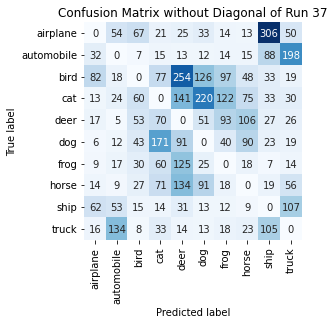

Summing down the rows, for Predicted Class total:  [251. 326. 310. 532. 828. 584. 428. 397. 641. 519.]
Summing across the columns, for True Class total:  [583. 394. 754. 718. 448. 495. 305. 439. 316. 364.]

 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 

   Begin Run:  38

 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38  

Dropout is:  0.6
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 100 , 100 )
ZoomOut: ( -0.0 , -0.0 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 24 , 24 )
blur: ( 7 , 7 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.1 , -0.1 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  1
pVerticalFlip:  0
pEqualize:  0
pFancyPCA:  0
pChannelShuffle:  1
pElasticTransform:  1
pToGray:  0
**************

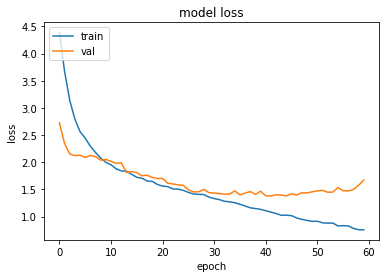

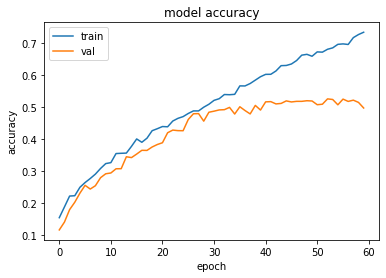

TestLoss:  1.3439521789550781  TestAcc: 0.5231999754905701
frog 0.678
ship 0.666
horse 0.632
automobile 0.628
truck 0.616
deer 0.587
airplane 0.495
dog 0.428
cat 0.274
bird 0.228


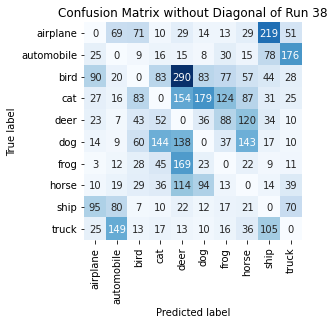

Summing down the rows, for Predicted Class total:  [312. 381. 343. 413. 944. 459. 415. 530. 551. 420.]
Summing across the columns, for True Class total:  [505. 372. 772. 726. 413. 572. 322. 368. 334. 384.]

 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 

   Begin Run:  39

 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39  

Dropout is:  0.4
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.0 , -0.0 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 0 , 0 )
blur: ( 7 , 7 )
sharp: ( 0.1 , 0.1 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 14 , 14 ) or ( -14 , -14 )
pHorizontalFlip:  1
pVerticalFlip:  1
pEqualize:  0
pFancyPCA:  1
pChannelShuffle:  0
pElasticTransform:  0
pToGray:  0
**********

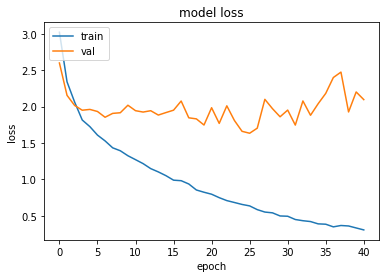

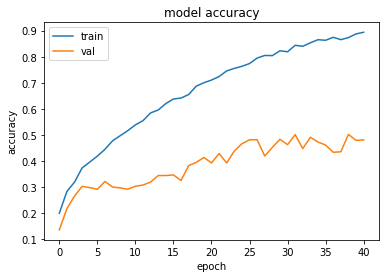

TestLoss:  1.5903435945510864  TestAcc: 0.4912000000476837
frog 0.692
deer 0.633
airplane 0.592
horse 0.556
truck 0.513
automobile 0.486
ship 0.486
dog 0.382
bird 0.371
cat 0.201


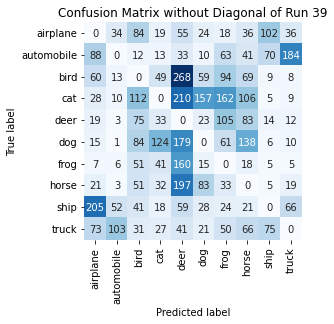

Summing down the rows, for Predicted Class total:  [ 516.  225.  541.  356. 1202.  420.  610.  578.  291.  349.]
Summing across the columns, for True Class total:  [408. 514. 629. 799. 367. 618. 308. 444. 514. 487.]

 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 

   Begin Run:  40

 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40  

Dropout is:  0.4
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 100 , 100 )
ZoomOut: ( -0.0 , -0.0 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 24 , 24 )
blur: ( 0 , 1 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.2 , -0.2 )
Rotate: ( 14 , 14 ) or ( -14 , -14 )
pHorizontalFlip:  1
pVerticalFlip:  0
pEqualize:  1
pFancyPCA:  1
pChannelShuffle:  0
pElasticTransform:  0
pToGray:  

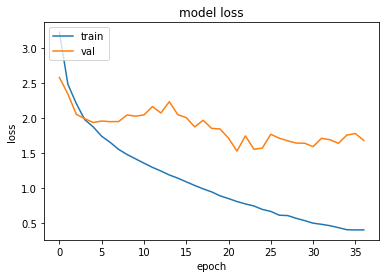

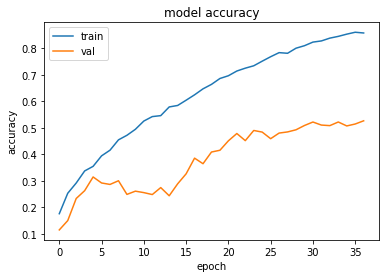

TestLoss:  1.4946403503417969  TestAcc: 0.486299991607666
frog 0.743
airplane 0.601
automobile 0.594
ship 0.565
truck 0.539
bird 0.497
deer 0.466
horse 0.386
dog 0.283
cat 0.189


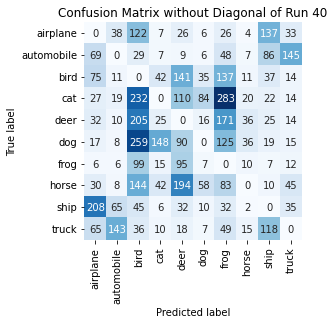

Summing down the rows, for Predicted Class total:  [ 529.  308. 1171.  302.  715.  229.  954.  141.  461.  327.]
Summing across the columns, for True Class total:  [399. 406. 503. 811. 534. 717. 257. 614. 435. 461.]

 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 

   Begin Run:  41

 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41  

Dropout is:  0.6
Shift X: ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 100 , 100 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 0 , 0 )
blur: ( 7 , 7 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 14 , 14 ) or ( -14 , -14 )
pHorizontalFlip:  1
pVerticalFlip:  0
pEqualize:  1
pFancyPCA:  0
pChannelShuffle:  0
pElasticTransform:  0
pToGray:  

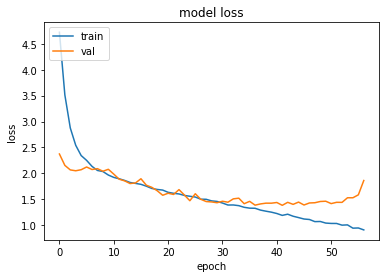

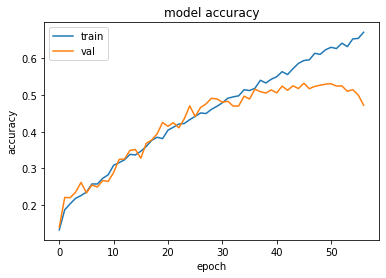

TestLoss:  1.352013349533081  TestAcc: 0.5342000126838684
frog 0.741
automobile 0.666
truck 0.644
ship 0.64
horse 0.637
deer 0.534
dog 0.531
airplane 0.414
cat 0.343
bird 0.192


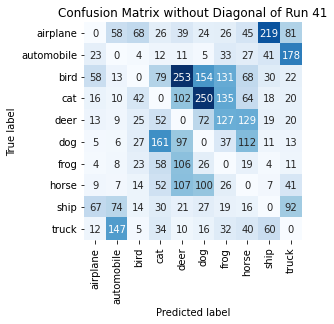

Summing down the rows, for Predicted Class total:  [207. 332. 222. 504. 746. 674. 566. 520. 409. 478.]
Summing across the columns, for True Class total:  [586. 334. 808. 657. 466. 469. 259. 363. 360. 356.]

 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 

   Begin Run:  42

 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42  

Dropout is:  0.4
Shift X: ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 100 , 100 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 0 , 0 )
blur: ( 7 , 7 )
sharp: ( 0.1 , 0.1 )
Contrast: ( 0.0 , 0.0 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.2 , -0.2 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  1
pVerticalFlip:  0
pEqualize:  0
pFancyPCA:  1
pChannelShuffle:  0
pElasticTransform:  0
pToGray:  0
****

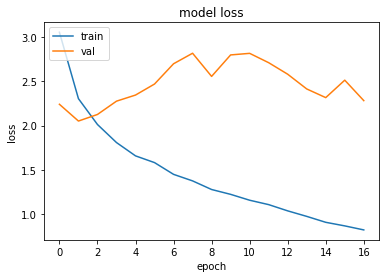

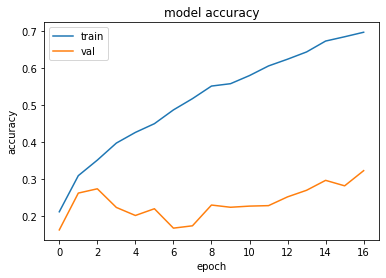

TestLoss:  2.045952320098877  TestAcc: 0.2614000141620636
airplane 0.833
dog 0.544
frog 0.471
deer 0.374
cat 0.197
horse 0.067
ship 0.056
automobile 0.04
bird 0.031
truck 0.001


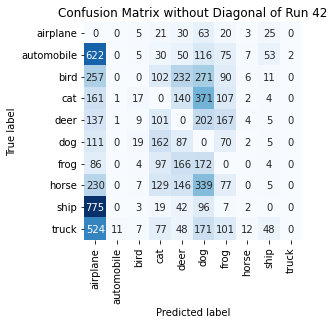

Summing down the rows, for Predicted Class total:  [2.903e+03 1.300e+01 7.600e+01 7.380e+02 9.410e+02 1.801e+03 7.140e+02
 3.800e+01 1.600e+02 2.000e+00]
Summing across the columns, for True Class total:  [167. 960. 969. 803. 626. 456. 529. 933. 944. 999.]

 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 

   Begin Run:  43

 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43  

Dropout is:  0.4
Shift X: ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 100 , 100 )
ZoomOut: ( -0.0 , -0.0 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 0 , 0 )
blur: ( 7 , 7 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 14 , 14 ) or ( -14 , -14 )
pHorizontalFlip:  0
pVerticalFlip:  1
pEqualize:  0
pFancyPCA:  1
pCh

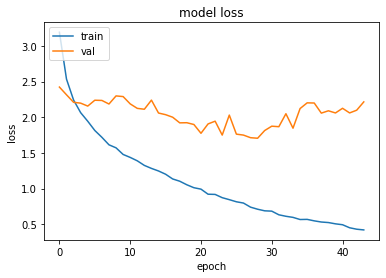

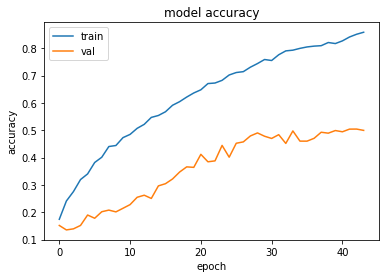

TestLoss:  1.683241605758667  TestAcc: 0.490200012922287
ship 0.745
deer 0.612
truck 0.611
horse 0.56
frog 0.554
automobile 0.524
airplane 0.44
cat 0.327
dog 0.305
bird 0.224


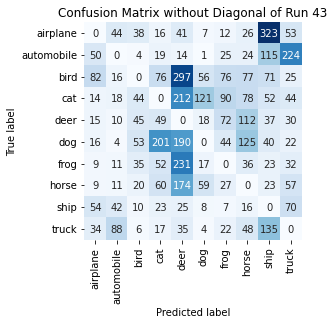

Summing down the rows, for Predicted Class total:  [ 283.  244.  255.  513. 1219.  291.  375.  542.  819.  557.]
Summing across the columns, for True Class total:  [560. 476. 776. 673. 388. 695. 446. 440. 255. 389.]

 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 

   Begin Run:  44

 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44  

Dropout is:  0.4
Shift X: ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 110 , 110 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 24 , 24 )
blur: ( 0 , 1 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 14 , 14 ) or ( -14 , -14 )
pHorizontalFlip:  1
pVerticalFlip:  1
pEqualize:  0
pFancyPCA:  1
pChannelShuffle:  1
pElasticTransform:  0
pToGray:

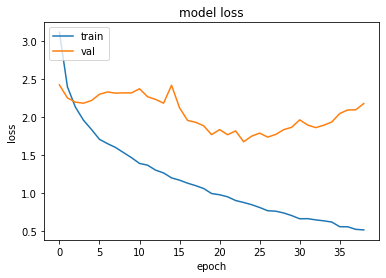

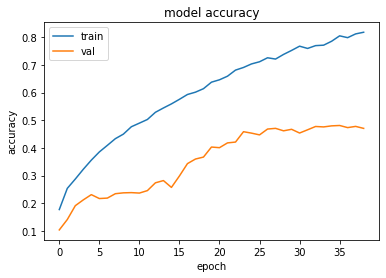

TestLoss:  1.6047577857971191  TestAcc: 0.4724000096321106
frog 0.633
ship 0.581
deer 0.577
horse 0.536
airplane 0.523
truck 0.514
automobile 0.415
dog 0.371
cat 0.361
bird 0.213


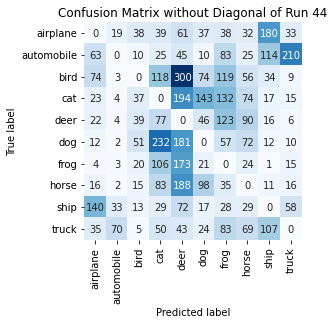

Summing down the rows, for Predicted Class total:  [ 389.  140.  228.  759. 1257.  470.  698.  471.  492.  372.]
Summing across the columns, for True Class total:  [477. 585. 787. 639. 423. 629. 367. 464. 419. 486.]

 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 

   Begin Run:  45

 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45  

Dropout is:  0.4
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 100 , 100 )
ZoomOut: ( -0.0 , -0.0 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 0 , 0 )
blur: ( 0 , 1 )
sharp: ( 0.1 , 0.1 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.2 , -0.2 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  1
pVerticalFlip:  1
pEqualize:  1
pFancyPCA:  0
pChannelShuffle:  1
pElasticTransform:  0
pToGray:  1
************

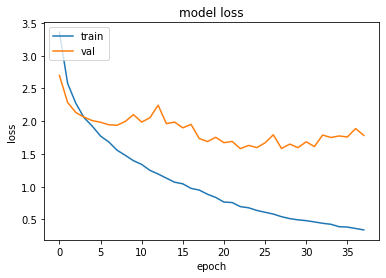

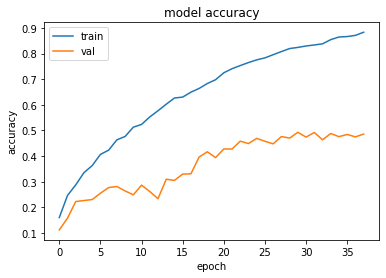

TestLoss:  1.5532445907592773  TestAcc: 0.4645000100135803
frog 0.837
ship 0.689
truck 0.549
automobile 0.478
horse 0.466
dog 0.365
cat 0.335
bird 0.315
deer 0.308
airplane 0.303


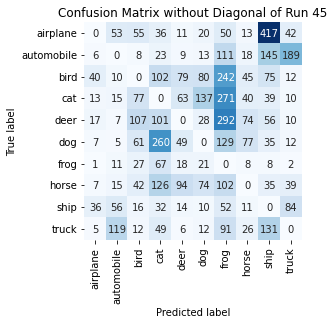

Summing down the rows, for Predicted Class total:  [ 132.  291.  405.  796.  343.  395. 1340.  312.  941.  400.]
Summing across the columns, for True Class total:  [697. 522. 685. 665. 692. 635. 163. 534. 311. 451.]

 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 

   Begin Run:  46

 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46  

Dropout is:  0.6
Shift X: ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 100 , 100 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 24 , 24 )
blur: ( 0 , 1 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.2 , -0.2 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  0
pVerticalFlip:  0
pEqualize:  1
pFancyPCA:  0
pChannelShuffle:  1
pElasticTransform:  1
pToGray:  1


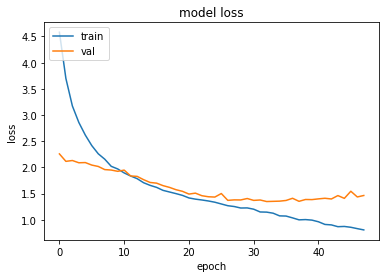

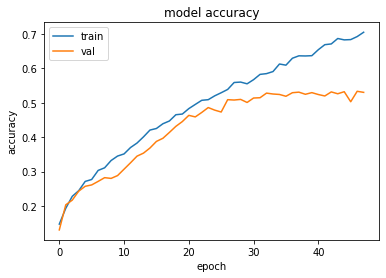

TestLoss:  1.3081165552139282  TestAcc: 0.5321000218391418
ship 0.685
truck 0.682
frog 0.655
horse 0.63
automobile 0.563
airplane 0.537
deer 0.466
dog 0.422
cat 0.418
bird 0.263


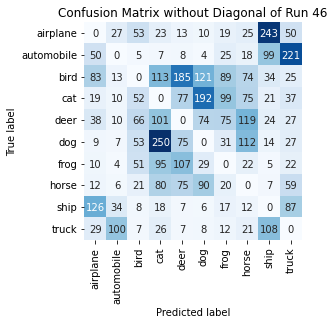

Summing down the rows, for Predicted Class total:  [376. 211. 316. 713. 554. 534. 387. 478. 555. 555.]
Summing across the columns, for True Class total:  [463. 437. 737. 582. 534. 578. 345. 370. 315. 318.]

 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 

   Begin Run:  47

 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47  

Dropout is:  0.4
Shift X: ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y: ( 0.0625 , 0.0625 )or ( -0.0625 , -0.0625 )
Gamma: ( 120 , 120 )
ZoomOut: ( -0.16 , -0.16 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 24 , 24 )
blur: ( 7 , 7 )
sharp: ( 0.0 , 0.0 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.2 , -0.2 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  1
pVerticalFlip:  0
pEqualize:  0
pFancyPCA:  0
pChannelShuffle:  1
pElasticTransform:  0
pToGray:  

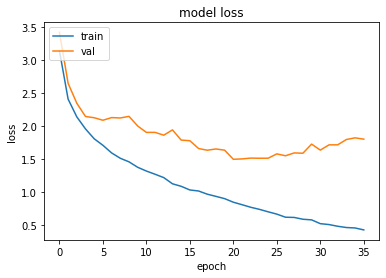

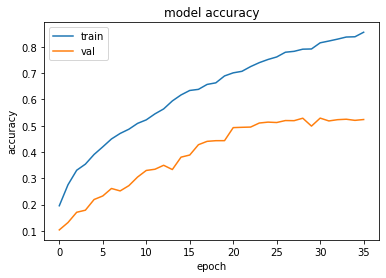

TestLoss:  1.4570389986038208  TestAcc: 0.49900001287460327
frog 0.722
ship 0.641
deer 0.623
truck 0.601
horse 0.54
airplane 0.523
automobile 0.397
dog 0.381
bird 0.308
cat 0.254


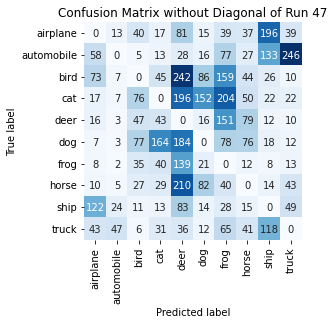

Summing down the rows, for Predicted Class total:  [ 354.  111.  324.  395. 1199.  414.  841.  381.  547.  444.]
Summing across the columns, for True Class total:  [477. 603. 692. 746. 377. 619. 278. 460. 359. 399.]

 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 

   Begin Run:  48

 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48  

Dropout is:  0.6
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma: ( 110 , 110 )
ZoomOut: ( -0.0 , -0.0 )
ZoomIn: ( 0.16 , 0.16 )
Noise: ( 0 , 0 )
blur: ( 7 , 7 )
sharp: ( 0.1 , 0.1 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.0 , 0.0 )
Darken: ( -0.2 , -0.2 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  0
pVerticalFlip:  0
pEqualize:  1
pFancyPCA:  0
pChannelShuffle:  0
pElasticTransform:  1
pToGray:  0
****

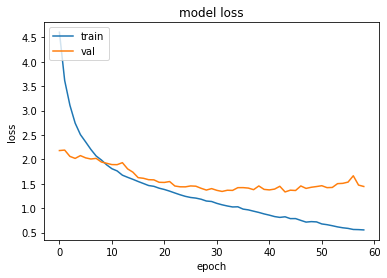

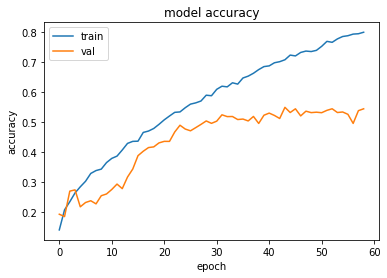

TestLoss:  1.2902694940567017  TestAcc: 0.5598999857902527
automobile 0.737
ship 0.689
frog 0.653
horse 0.638
truck 0.623
dog 0.567
airplane 0.517
deer 0.451
cat 0.375
bird 0.349


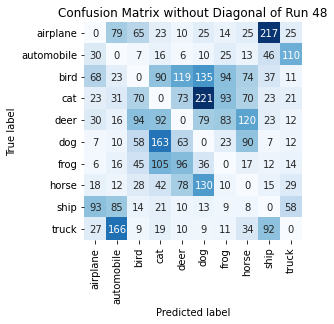

Summing down the rows, for Predicted Class total:  [302. 438. 390. 571. 465. 658. 362. 451. 472. 292.]
Summing across the columns, for True Class total:  [483. 263. 651. 625. 549. 433. 347. 362. 311. 377.]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download attempted :  Thu, 11 November 2021 15:40:19  (subtract 3-hours from Hour), and file is called  .pkl

 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 

   Begin Run:  49

 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49  

Dropout is:  0.6
Shift X: ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y: ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma: ( 100 , 100 )
ZoomOut: ( -0.0 , -0.0 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 12 , 12 )
blur: ( 7 , 7 )
sharp: ( 0.1 , 0.1 )
Contrast: ( 0.2 , 0.2 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.2 , -0.2 )
Rotate: ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:  0
pVerticalFlip:  1
pEqualize:  0
pFancyPCA:  1
pChannelShuffle:  0
pElasticTransform:  0
pToGray:  1
**************************************************************************************************** 


train_X

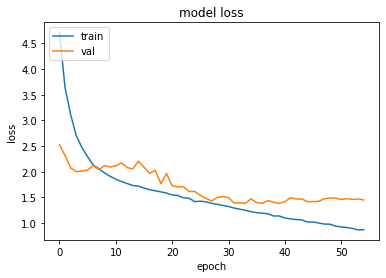

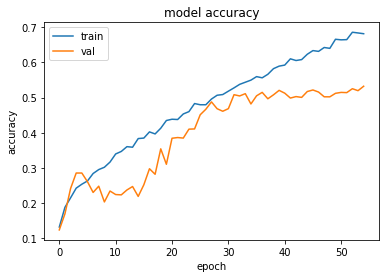

TestLoss:  1.341296911239624  TestAcc: 0.5250999927520752
frog 0.793
ship 0.656
truck 0.611
airplane 0.559
automobile 0.543
deer 0.499
dog 0.498
horse 0.464
bird 0.364
cat 0.264


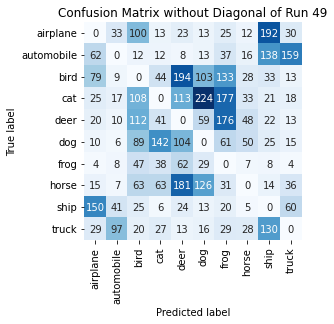

Summing down the rows, for Predicted Class total:  [394. 228. 576. 386. 722. 596. 689. 227. 583. 348.]
Summing across the columns, for True Class total:  [441. 457. 636. 736. 501. 502. 207. 536. 344. 389.]

 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 

   Begin Run:  50

 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50  

Dropout is:  0.6
Shift X: ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y: ( 0.0625 , 0.0625 )or ( -0.0625 , -0.0625 )
Gamma: ( 100 , 100 )
ZoomOut: ( -0.0 , -0.0 )
ZoomIn: ( 0.0 , 0.0 )
Noise: ( 0 , 0 )
blur: ( 0 , 1 )
sharp: ( 0.1 , 0.1 )
Contrast: ( 0.0 , 0.0 )
Bright: ( 0.2 , 0.2 )
Darken: ( -0.0 , -0.0 )
Rotate: ( 14 , 14 ) or ( -14 , -14 )
pHorizontalFlip:  0
pVerticalFlip:  1
pEqualize:  1
pFancyPCA:  1
pChannelShuffle:  0
pElasticTransform:  1
pToGray:  0
******

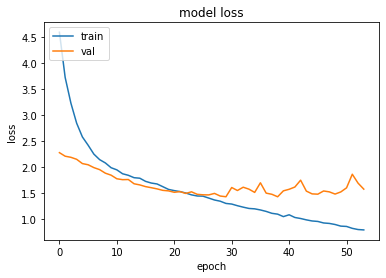

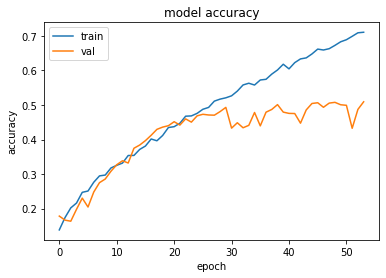

TestLoss:  1.3871009349822998  TestAcc: 0.5133000016212463
frog 0.735
automobile 0.715
dog 0.57
ship 0.566
airplane 0.532
horse 0.51
truck 0.473
deer 0.467
bird 0.309
cat 0.256


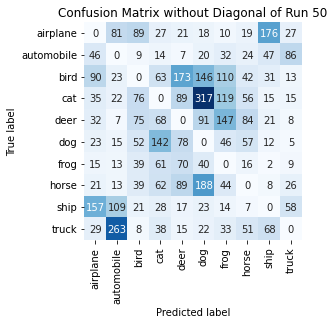

Summing down the rows, for Predicted Class total:  [448. 546. 408. 503. 559. 865. 555. 356. 380. 247.]
Summing across the columns, for True Class total:  [468. 285. 691. 744. 533. 430. 265. 490. 434. 527.]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Final Download attempted :  Thu, 11 November 2021 15:42:42  (subtract 3-hours from Hour), and file is called runs_groupX_final.pkl 


In [187]:
run_through_runs(ds=make_unbatched(train_B), ds_noalb=train_B_noalb, dstitle="B" , showpictures= False)

In [ ]:
run_through_runs(ds=make_unbatched(train_C), dstitle="C" , showpictures= True)

# Time Required



In [191]:
stop_testing = time.time()
print((stop_testing - tic) , "secs to  run everything start to end, or... ")
print((stop_testing - tic)/60, "minutes ... or ")
print((stop_testing - tic)/3600, "hours ")

14902.993225574493 secs to  run everything start to end, or... 
248.38322042624156 minutes ... or 
4.13972034043736 hours 


# Post-Test: View Results

After the 50 runs above have run, its time to load the results into JMP to Fit the Definitive Screening Design and find which Main Effects have the most compeling effect.  This is my second time running the results of Training_Group_A.  The first time I created two for loops to go through the first 25 runs and save, and then the second 25 runs and save.  When I went through my results, the second 25 runs on average were slightly less test accuracy (diff of 0.03 according to block effect), and you could clearly see that each run of view_images(data) resulted in the exact same images.  So my belief is that for some reason, maybe due to a coding issue, or maybe just an artifact of calling up the dataset-augmentations "twice", the second 25 runs in the original "[Test1](https://github.com/RachelRamirez/CIFAR-10/blob/main/CollectionofTests/Test1GroupA.ipynb)" resulted in a visible block effect.  It was funny because I had made a block variable and then accidentally caused a significant blocking effect.. ANYWHO...  


In [ ]:
import pickle
import numpy as np
with open('runs_groupA (8).pkl', 'rb') as fid:
     lastruns_groupA_loaded = pickle.load(fid)  #this file originally saved 11-5-2021 from 1 each testset

lastruns_groupA_loaded

string_of_cm = " "
y = {}

# test
# string_of_cm = string_of_cm + np.array2string(lastruns_groupA_loaded[0]["CM"][0][0]) + " "
print("Run ,", "Test Accuracy ,", "Test Loss,", "Confusion Matrix Diagonals," )
 
CM_digit = []

for i in range(0,ENDRUNS):
  for x in range(0,10):
    #string_of_cm = string_of_cm + np.array2string(lastruns_groupA_loaded[i]["CM"][x][x]) + ", "
    CM_digit = lastruns_groupA_loaded[i]["CM"][x][x] + CM_digit
  y[i] = lastruns_groupA_loaded[i]['TestAccuracy'], lastruns_groupA_loaded[i]["TestLoss"], CM_digit 
  print(y[i])
  CM_digit = [] #clear?

lastruns_groupA_loaded[1]["TestAccuracy"]
lastruns_groupA_loaded[1]["CM"][:,0].sum()  #666 Predicted Class 0?
lastruns_groupA_loaded[1]["CM"][0,:].sum()  #1000 True Class 0?
lastruns_groupA_loaded[1]["CM"][1,:].sum()  #1000 True Class 1?

sum_of_cm_diagonals = 0
for i in range(10):
  sum_of_cm_diagonals = sum_of_cm_diagonals + lastruns_groupA_loaded[1]["CM"][i,i]    

print("Sum of Diagonals on Confusion Matrix of Run 1: ", sum_of_cm_diagonals) #checks with TestAccuracy


#I want to find the area of greatest confusion

#create a new matrix to not ruin previious CM
confusion_matrix_wo_diagonal = lastruns_groupA_loaded[1]["CM"].copy()
 
for i in range(10):
  confusion_matrix_wo_diagonal[i,i] = 0 # set the diagonal equal to zero
print(confusion_matrix_wo_diagonal)
# for i in range(10):
#   print(i, "is most often miscategorized as ", np.argmax(confusion_matrix_wo_diagonal[:,i]), " ", max(confusion_matrix_wo_diagonal[:,i]), " times")

for i in range(10):
  print("The algorithm predicted a ", np.argmax(confusion_matrix_wo_diagonal[i,:]),"instead of a ",  i, " ", max(confusion_matrix_wo_diagonal[i,:]), "times")



print("Summing down the rows, for COLUMN total: ", confusion_matrix_wo_diagonal.sum(axis=0))
print("Summing across the columns, for ROW total: ", confusion_matrix_wo_diagonal.sum(axis=1))

something weird about the above code.  My confusion matrix looks like its lost the diagonals. I think copying to confusion_matrix_wo_diagonal didn't do a separate copy, it is just linked, so when I cleared the diagonal of confusion_matrix_wo_diagonal, it also cleared it from lastruns_groupsA_loaded[1]["CM"]


In [ ]:
lastruns_groupA_loaded[0]["CM"]

In [ ]:
confusion_matrix_wo_diagonal.sum() + sum_of_cm_diagonals

In [ ]:
string_of_cm = ""

for i in range(1,2):  # goes through first n runs with CMs
  for x in range(10): # goes through the n items in diagonal of each run.CM
    string_of_cm = string_of_cm + np.array2string(lastruns_groupA_loaded[i]["CM"][x][x]) + ","
    y[i] = lastruns_groupA_loaded[i]['TestAccuracy'], lastruns_groupA_loaded[i]["TestLoss"], string_of_cm 
  print(y[i])
  

lastruns_groupA_loaded[1]["TestAccuracy"]
lastruns_groupA_loaded[1]["CM"][:,0].sum()  #666 Predicted Class 0
lastruns_groupA_loaded[1]["CM"][0,:].sum()  #1000 True Class 0
lastruns_groupA_loaded[1]["CM"][1,:].sum()  #1000 True Class 1

sum_of_cm_diagonals = 0
for i in range(10):
  sum_of_cm_diagonals = sum_of_cm_diagonals + lastruns_groupA_loaded[1]["CM"][i,i]    

print("Sum of Diagonals on Confusion Matrix of Run 1: ", sum_of_cm_diagonals) #checks with TestAccuracy


#I want to find the area of greatest confusion

#create a new matrix to not ruin previious CM
confusion_matrix_wo_diagonal = lastruns_groupA_loaded[1]["CM"].copy()
 
for i in range(10):
  confusion_matrix_wo_diagonal[i,i] = 0 # set the diagonal equal to zero
print(confusion_matrix_wo_diagonal)
# for i in range(10):
#   print(i, "is most often miscategorized as ", np.argmax(confusion_matrix_wo_diagonal[:,i]), " ", max(confusion_matrix_wo_diagonal[:,i]), " times")

for i in range(10):
  print("The algorithm predicted a ", np.argmax(confusion_matrix_wo_diagonal[i,:]),"instead of a ",  i, " ", max(confusion_matrix_wo_diagonal[i,:]), "times")



print("Summing down the rows, for COLUMN total: ", confusion_matrix_wo_diagonal.sum(axis=0))
print("Summing across the columns, for ROW total: ", confusion_matrix_wo_diagonal.sum(axis=1))